# Smart-Light Split-Lead Autoencoder for ECG Analysis

## Introduction and Objective
This notebook presents a novel **Smart-Light Split-Lead Autoencoder** architecture designed for the unsupervised feature extraction from 12-lead ECG signals. The primary objective is to learn a compressed latent representation that captures the underlying cardiac physiology, which is subsequently utilized for patient classification.

The workflow integrates these learned features with tabular clinical data to enhance diagnostic accuracy. The methodology is structured as follows:
1.  **Signal Preprocessing**: Filtering and normalization of raw ECG data.
2.  **Deep Learning**: Training a Split-Lead Autoencoder with Attention mechanisms.
3.  **Feature Aggregation**: Deriving patient-level metrics from window-level latent vectors.
4.  **Multimodal Fusion**: Combining ECG features with clinical metadata.
5.  **Classification**: Training a classifier on the fused dataset.


## 1. Environment Setup and Reproducibility

This section imports the libraries and fixes randomness.
The goal is to make results easier to reproduce.



In [1]:
# ==== CELL 2: Library Imports =================================================
import os
import copy
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
    classification_report
)
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation Device: {device}")


Computation Device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ==== CELL 3: Initial Configuration (Signal Processing) =======================
# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# --- Signal Processing ---
FS_SIGNAL   = 500    # Sampling Frequency (Hz)
WINDOW_SIZE = 1000   # Window length (samples) -> ~2 seconds
STRIDE      = 250    # Stride (samples) -> 75% overlap

print("Signal processing parameters configured.")


Signal processing parameters configured.


In [4]:
# ==== CELL 4: Data Paths ======================================================
# Update these paths as needed for your environment
# BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Google Collab/NeuroEng_PW_2x3"

EXCEL_1 = os.path.join("/content/drive/MyDrive/Colab Notebooks/Google Collab/NeuroEng_PW_2x3/VALETUDO_database_1st_batch_en_all_info.xlsx")
EXCEL_2 = os.path.join("/content/drive/MyDrive/Colab Notebooks/Google Collab/NeuroEng_PW_2x3/VALETUDO_database_2nd_batch_en_all_info.xlsx")

ECG_DIR_1 = os.path.join('/content/drive/MyDrive/Colab Notebooks/Google Collab/NeuroEng_PW_2x3/1_batch_extracted')
ECG_DIR_2 = os.path.join('/content/drive/MyDrive/Colab Notebooks/Google Collab/NeuroEng_PW_2x3/2_batch_extracted')

print(f"ECG Batch 1: {ECG_DIR_1}")
print(f"ECG Batch 2: {ECG_DIR_2}")
print(f"Excel 1: {EXCEL_1}")
print(f"Excel 2: {EXCEL_2}")


ECG Batch 1: /content/drive/MyDrive/Colab Notebooks/Google Collab/NeuroEng_PW_2x3/1_batch_extracted
ECG Batch 2: /content/drive/MyDrive/Colab Notebooks/Google Collab/NeuroEng_PW_2x3/2_batch_extracted
Excel 1: /content/drive/MyDrive/Colab Notebooks/Google Collab/NeuroEng_PW_2x3/VALETUDO_database_1st_batch_en_all_info.xlsx
Excel 2: /content/drive/MyDrive/Colab Notebooks/Google Collab/NeuroEng_PW_2x3/VALETUDO_database_2nd_batch_en_all_info.xlsx


## 2. ECG Data Loading and Signal Preprocessing

We load raw 12-lead ECG signals and apply filtering to reduce noise.

**Pipeline**
1. Centering (remove mean)
2. Bandpass filter (keeps the physiological band)
3. Notch filter (removes power-line interference)

**Why this matters**
Filtering improves reconstruction stability and helps the model focus on morphology instead of artifacts.


In [5]:
# ==== CELL 5: Preprocessing Functions =========================================
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=0.5, highcut=40, fs=500, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=500, quality_factor=30):
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)


In [6]:
# ==== CELL 4: Load and Filter Data ==========================================
ECG_folder = ECG_DIR_1
ECG_folder_2batch = ECG_DIR_2

tabular_data = pd.read_excel(EXCEL_1)
tabular_data_2batch = pd.read_excel(EXCEL_2)

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(ECG_folder) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(ECG_folder_2batch) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))
signals_2 = np.empty((len(ECGs_2), 5000, 12))

print("Loading and filtering batch 1...")
for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(ECG_folder, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_1[index, :, :] = ecg

print("Loading and filtering batch 2...")
for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(ECG_folder_2batch, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg

# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)

Loading and filtering batch 1...
Loading and filtering batch 2...
Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 18)


## 3. Patient-wise Split and Windowing

We segment each ECG into fixed-length windows.
Splits are done at **patient level** to prevent train/val leakage.

**Key choices**
- Window length: fixed number of samples
- Window stride / overlap: controls how many windows per patient
- Stratification: keeps class balance across splits when labels are available

**Output**
A windowed dataset where each sample is a multi-lead ECG segment.


In [7]:
# ==== CELL 7: Patient Split and Windowing =====================================
# tensor ECG: [N, 12, 5000]
signals_tensor = torch.tensor(signals, dtype=torch.float32).permute(0, 2, 1)
labels_tensor  = torch.tensor(tabular_data["sport_ability"].values, dtype=torch.long)
patient_ids    = torch.tensor(tabular_data["ECG_patient_id"].values, dtype=torch.long)
ecg_ids_np     = tabular_data["ECG_patient_id"].values

# Patient-wise split
patient_df   = tabular_data[["ECG_patient_id", "sport_ability"]].drop_duplicates()
unique_ids   = patient_df["ECG_patient_id"].values
labels_unique = patient_df["sport_ability"].values

train_ids, test_ids = train_test_split(
    unique_ids,
    test_size=0.2,
    random_state=SEED,
    stratify=labels_unique,
)
train_labels_split = labels_unique[np.isin(unique_ids, train_ids)]
train_ids, val_ids = train_test_split(
    train_ids,
    test_size=0.2,
    random_state=SEED,
    stratify=train_labels_split,
)

print(f"Total patients: {len(unique_ids)}")
print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

def make_windows(selected_ids):
    """
    Creates windows of shape [num_windows, 12, WINDOW_SIZE].
    Keeps all 12 leads together.
    """
    mask = np.isin(ecg_ids_np, selected_ids)
    subset_signals = signals_tensor[torch.from_numpy(mask)]  # [N_sel, 12, 5000]
    subset_labels  = labels_tensor[torch.from_numpy(mask)]   # [N_sel]
    subset_ids     = patient_ids[torch.from_numpy(mask)]     # [N_sel]

    windows_list, labels_list, ids_list = [], [], []

    for ecg, lab, pid in zip(subset_signals, subset_labels, subset_ids):
        ecg_np = ecg.numpy()   # [12, 5000]
        n_samples = ecg_np.shape[1]

        for start in range(0, n_samples - WINDOW_SIZE + 1, STRIDE):
            end = start + WINDOW_SIZE
            win12 = ecg_np[:, start:end]      # [12, WINDOW_SIZE]

            # Keep 12 leads together
            windows_list.append(win12)
            labels_list.append(lab.item())
            ids_list.append(pid.item())

    x = torch.tensor(np.stack(windows_list), dtype=torch.float32)  # [N_win, 12, win]
    y = torch.tensor(labels_list, dtype=torch.long)
    p = torch.tensor(ids_list, dtype=torch.long)
    return x, y, p

x_train_win, y_train_win, pid_train = make_windows(train_ids)
x_val_win,   y_val_win,   pid_val   = make_windows(val_ids)
x_test_win,  y_test_win,  pid_test  = make_windows(test_ids)

print("Train windows:", x_train_win.shape)
print("Val windows:  ", x_val_win.shape)
print("Test windows: ", x_test_win.shape)


Total patients: 526
Train: 336, Val: 84, Test: 106
Train windows: torch.Size([5712, 12, 1000])
Val windows:   torch.Size([1428, 12, 1000])
Test windows:  torch.Size([1802, 12, 1000])


In [8]:
# ==== CELL 8: Normalization ===================================================
x_train_raw = x_train_win.clone()
x_val_raw   = x_val_win.clone()
x_test_raw  = x_test_win.clone()

# Normalize using training statistics
train_mean = x_train_win.mean(dim=(0, 2), keepdim=True)
train_std  = x_train_win.std(dim=(0, 2), keepdim=True).clamp_min(1e-6)

x_train_norm = (x_train_win - train_mean) / train_std
x_val_norm   = (x_val_win   - train_mean) / train_std
x_test_norm  = (x_test_win  - train_mean) / train_std

# Create Datasets
train_dataset = TensorDataset(x_train_norm, y_train_win)
val_dataset   = TensorDataset(x_val_norm,   y_val_win)
test_dataset  = TensorDataset(x_test_norm,  y_test_win)


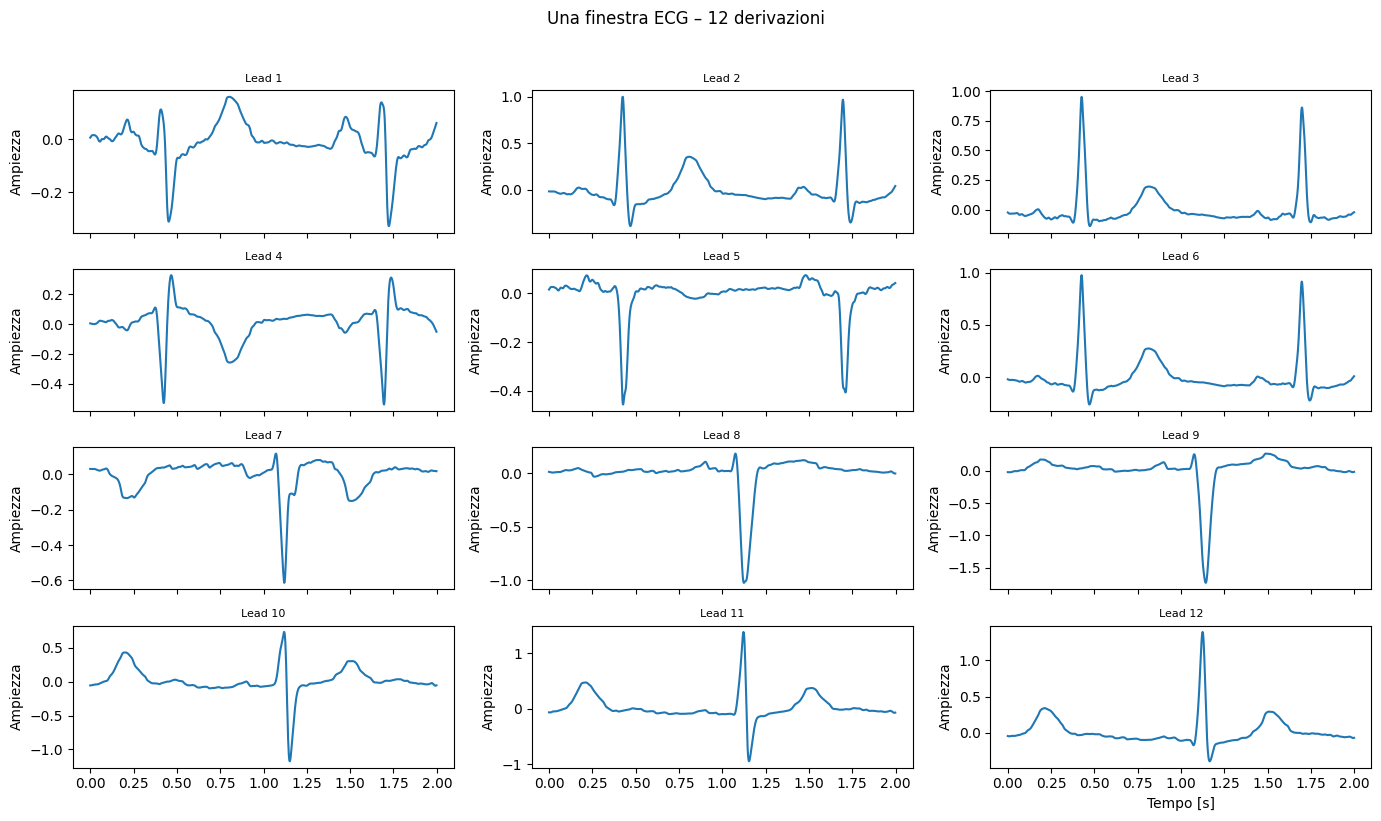

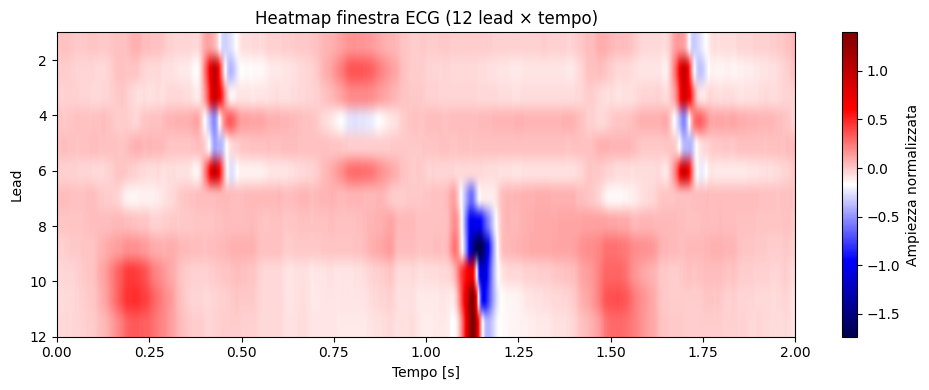

In [9]:
# ==== EXTRA C: Una finestra 12-lead e heatmap ===============================
import matplotlib.pyplot as plt

# Prendiamo la prima finestra del train
sample = x_train_raw[0].numpy()  # [12, WINDOW_SIZE]
t = np.arange(WINDOW_SIZE) / FS_SIGNAL

lead_names = [f"Lead {i}" for i in range(1, 13)]

# Plot 12 sottografi
fig, axes = plt.subplots(4, 3, figsize=(14, 8), sharex=True)
axes = axes.flatten()

for i in range(12):
    axes[i].plot(t, sample[i, :])
    axes[i].set_title(lead_names[i], fontsize=8)
    axes[i].set_ylabel("Ampiezza")

axes[-1].set_xlabel("Tempo [s]")
plt.suptitle("Una finestra ECG – 12 derivazioni", y=1.02)
plt.tight_layout()
plt.show()

# Heatmap 2D (lead vs tempo)
plt.figure(figsize=(10, 4))
plt.imshow(sample, aspect="auto", cmap="seismic",
           extent=[0, WINDOW_SIZE / FS_SIGNAL, 12, 1])
plt.colorbar(label="Ampiezza normalizzata")
plt.xlabel("Tempo [s]")
plt.ylabel("Lead")
plt.title("Heatmap finestra ECG (12 lead × tempo)")
plt.tight_layout()
plt.show()


## 4. Model Architecture: Smart-Light Split-Lead Autoencoder
The proposed architecture features a **Split-Lead** design, processing the first 6 leads (precordial) and the last 6 leads (limb) through separate encoders.


In [10]:
# ==== CELL 9: Model & Training Hyperparameters ================================
# --- Model Architecture ---
LATENT_DIM  = 32     # Dimension of the latent space (Z)

# --- Training ---
BATCH_SIZE  = 32
LR_INITIAL  = 1e-3   # Initial Learning Rate
LR_FINE     = 5e-5   # Fine-tuning Learning Rate
NUM_EPOCHS  = 200    # Total Epochs
PRETRAIN_EPOCHS = 100 # Max epochs for reconstruction-only phase

# Loss Weights
ALPHA = 0.2  # Reconstruction Loss Weight

BETA  = 0.4  # Classification Loss Weight

# Early Stopping
PATIENCE_REC = 5     # Patience for reconstruction phase
PATIENCE_F1  = 15    # Patience for fine-tuning phase

# --- Classification (Random Forest) ---
RF_ESTIMATORS = 200
RF_MAX_DEPTH  = 8

print("Model and Training parameters configured.")


Model and Training parameters configured.


In [11]:
# ==== CELL 10: DataLoaders ====================================================
# Create DataLoaders (Requires BATCH_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                          shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE,
                          shuffle=False)

print(f"DataLoaders created with Batch Size: {BATCH_SIZE}")


DataLoaders created with Batch Size: 32


In [12]:
# ==== CELL 11: Smart-Light Split-Lead AE (With Attention & Mish) ============

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block.
    Acts as a channel-wise attention mechanism.
    """
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.Mish(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class SmartConvBlock(nn.Module):
    """
    Conv -> BN -> Mish -> SE-Attention
    """
    def __init__(self, in_c, out_c, kernel_size=5, stride=2, padding=2):
        super().__init__()
        self.conv = nn.Conv1d(in_c, out_c, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_c)
        self.act = nn.Mish()
        self.se = SEBlock(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.se(x)
        return x

class SmartTransposeBlock(nn.Module):
    """
    ConvTranspose -> BN -> Mish (No SE in decoder)
    """
    def __init__(self, in_c, out_c, kernel_size=5, stride=2, padding=2, output_padding=0):
        super().__init__()
        self.deconv = nn.ConvTranspose1d(in_c, out_c, kernel_size, stride, padding, output_padding)
        self.bn = nn.BatchNorm1d(out_c)
        self.act = nn.Mish()

    def forward(self, x):
        return self.act(self.bn(self.deconv(x)))

class ECG_AE(nn.Module):
    def __init__(self, input_len=WINDOW_SIZE, latent_dim=LATENT_DIM, n_classes=2):
        super().__init__()

        self.half_latent = latent_dim // 2

        # --- ENCODER "SMART" ---
        def build_smart_encoder():
            return nn.Sequential(
                SmartConvBlock(6, 8),
                SmartConvBlock(8, 16),
                SmartConvBlock(16, 32),
                SmartConvBlock(32, 64),
            )

        self.encoder_1 = build_smart_encoder()
        self.encoder_2 = build_smart_encoder()

        # === AUTOMATIC DIMENSION CALCULATION ===
        with torch.no_grad():
            dummy_input = torch.zeros(1, 6, input_len)
            dummy_output = self.encoder_1(dummy_input)
            self.enc_out_channels = dummy_output.shape[1]
            self.enc_out_len      = dummy_output.shape[2]
            self.flatten_dim      = dummy_output.numel()
            print(f"Smart-Light Shape -> Ch: {self.enc_out_channels}, T: {self.enc_out_len}, Flat: {self.flatten_dim}")

        # Bottleneck
        self.fc_encode_1 = nn.Linear(self.flatten_dim, self.half_latent)
        self.fc_encode_2 = nn.Linear(self.flatten_dim, self.half_latent)

        # --- DECODER ---
        self.fc_decode_1 = nn.Linear(self.half_latent, self.flatten_dim)
        self.fc_decode_2 = nn.Linear(self.half_latent, self.flatten_dim)

        def build_smart_decoder():
            return nn.Sequential(
                SmartTransposeBlock(64, 32, output_padding=0),
                SmartTransposeBlock(32, 16, output_padding=1),
                SmartTransposeBlock(16, 8, output_padding=1),
                nn.ConvTranspose1d(8, 6, kernel_size=5, stride=2, padding=2, output_padding=1),
            )

        self.decoder_1 = build_smart_decoder()
        self.decoder_2 = build_smart_decoder()


        # --- CLASSIFIER (Opzione 2: Norm-Heavy / Transformer Style) ---
        self.classifier = nn.Sequential(
            # 1. LAYER NORM (Il segreto della stabilità)
            # Normalizza il vettore z di OGNI paziente singolarmente.
            # Rende il modello meno sensibile all'ampiezza del segnale (es. paziente magro vs obeso).
            nn.LayerNorm(latent_dim),

            # 2. FEATURE MIXING (32 -> 32)
            # Manteniamo la stessa dimensione per permettere al modello di
            # combinare le feature senza comprimerle subito.
            nn.Linear(latent_dim, latent_dim),
            nn.Mish(), # Attivazione curva (Mish) per fluidità

            # 3. REGOLARIZZAZIONE
            nn.Dropout(0.5), # Spegne il 50% dei neuroni per evitare overfit

            # 4. DECISIONE FINALE
            nn.Linear(latent_dim, n_classes)
        )

    def forward(self, x):
        x1, x2 = x[:, 0:6, :], x[:, 6:12, :]

        f1 = self.encoder_1(x1)
        f2 = self.encoder_2(x2)

        z1 = self.fc_encode_1(f1.view(f1.size(0), -1))
        z2 = self.fc_encode_2(f2.view(f2.size(0), -1))

        z_cat = torch.cat([z1, z2], dim=1)

        rec1_in = self.fc_decode_1(z1).view(x.size(0), self.enc_out_channels, self.enc_out_len)
        rec2_in = self.fc_decode_2(z2).view(x.size(0), self.enc_out_channels, self.enc_out_len)

        x_hat = torch.cat([self.decoder_1(rec1_in), self.decoder_2(rec2_in)], dim=1)
        logits = self.classifier(z_cat)

        return x_hat, z_cat, logits

# Quick check
m = ECG_AE(input_len=WINDOW_SIZE)
print(f"Smart-Light Model Parameters: {sum(p.numel() for p in m.parameters() if p.requires_grad):,}")


Smart-Light Shape -> Ch: 64, T: 63, Flat: 4032
Smart-Light Model Parameters: 325,838


Smart-Light Shape -> Ch: 64, T: 63, Flat: 4032

 >>> TOTAL TRAINABLE PARAMETERS: 325,838 <<<


=== MODEL GRAPH (Visual) ===


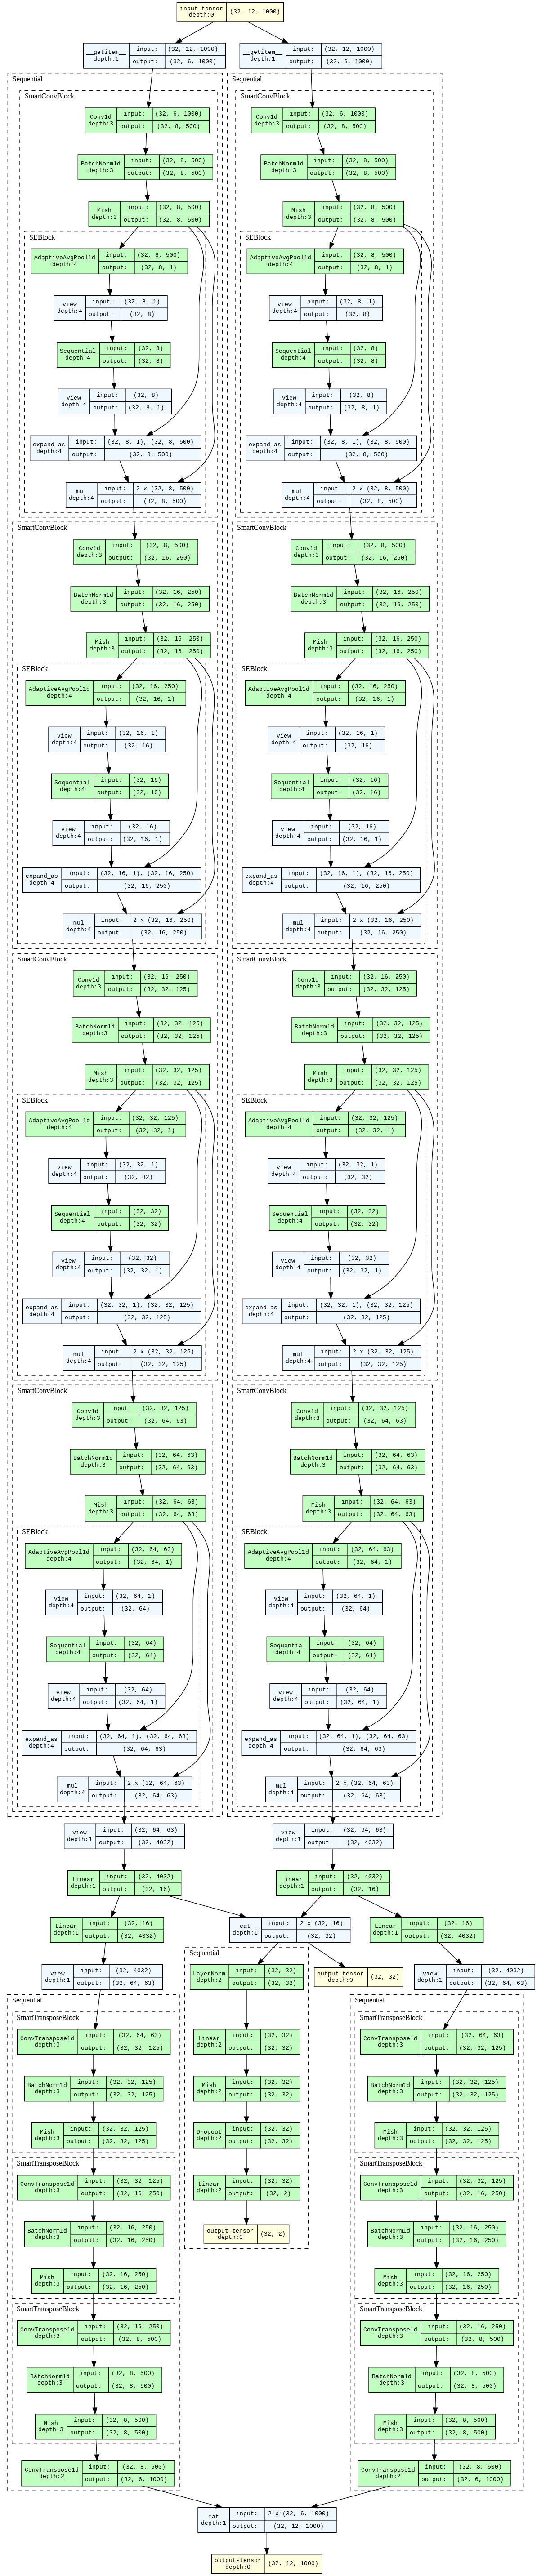

In [70]:
# ==== CELL 12: Sanity Check & Advanced Visualization ========================

# 1. Install libraries (if missing)
try:
    from torchinfo import summary
    from torchview import draw_graph
    import graphviz
except ImportError:
    print("Installing torchinfo, torchview, graphviz...")
    !pip install -q torchinfo torchview graphviz
    from torchinfo import summary
    from torchview import draw_graph
    import graphviz

graphviz.set_jupyter_format('png')

# 2. Instantiate model
n_classes = 2
model_check = ECG_AE(input_len=WINDOW_SIZE, latent_dim=LATENT_DIM, n_classes=n_classes).to(device)

# Define input dimensions
INPUT_SHAPE = (BATCH_SIZE, 12, WINDOW_SIZE)

# --- Calculate and Print Trainable Parameters ---
total_params = sum(p.numel() for p in model_check.parameters() if p.requires_grad)
print(f"\n{'='*40}")
print(f" >>> TOTAL TRAINABLE PARAMETERS: {total_params:,} <<<")
print(f"{'='*40}\n")


print("\n=== MODEL GRAPH (Visual) ===")
model_graph = draw_graph(
    model_check,
    input_size=INPUT_SHAPE,
    expand_nested=True,
    depth=4,
    save_graph=True,
    filename="ecg_ae_architecture",
    device=device
)
model_graph.visual_graph


## 5. Training Strategy
The training process employs a dual-phase approach with hyperparameters defined in the configuration section.


In [14]:
model = ECG_AE(input_len=WINDOW_SIZE, latent_dim=LATENT_DIM, n_classes=2).to(device)


Smart-Light Shape -> Ch: 64, T: 63, Flat: 4032


Starting training...
Phase 1: Pre-training (Rec Only) max 100 epochs.
Phase 2: Fine-tuning (Rec + Cls) starts automatically after Phase 1.
Epoch 001/200 [PRE ] | Trn: L=0.6175 (R=0.6175 C=0.7257) F1=0.4957) | Val: L=0.3025 (R=0.3025 C=0.7147 F1=0.4900)
Epoch 002/200 [PRE ] | Trn: L=0.3546 (R=0.3546 C=0.7254) F1=0.4909) | Val: L=0.2481 (R=0.2481 C=0.7138 F1=0.4964)
Epoch 003/200 [PRE ] | Trn: L=0.3116 (R=0.3116 C=0.7244) F1=0.4950) | Val: L=0.2282 (R=0.2282 C=0.7164 F1=0.4881)
Epoch 004/200 [PRE ] | Trn: L=0.2871 (R=0.2871 C=0.7243) F1=0.5029) | Val: L=0.2150 (R=0.2150 C=0.7156 F1=0.4914)
Epoch 005/200 [PRE ] | Trn: L=0.2699 (R=0.2699 C=0.7284) F1=0.4914) | Val: L=0.2062 (R=0.2062 C=0.7149 F1=0.4979)
Epoch 006/200 [PRE ] | Trn: L=0.2588 (R=0.2588 C=0.7228) F1=0.5014) | Val: L=0.1983 (R=0.1983 C=0.7163 F1=0.4856)
Epoch 007/200 [PRE ] | Trn: L=0.2477 (R=0.2477 C=0.7250) F1=0.5035) | Val: L=0.1921 (R=0.1921 C=0.7160 F1=0.4824)
Epoch 008/200 [PRE ] | Trn: L=0.2402 (R=0.2402 C=0.7264) F1=0.4

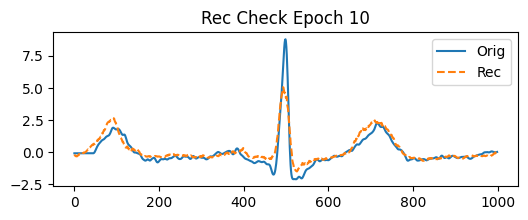

Epoch 011/200 [PRE ] | Trn: L=0.2169 (R=0.2169 C=0.7285) F1=0.4842) | Val: L=0.1736 (R=0.1736 C=0.7178 F1=0.4778)
Epoch 012/200 [PRE ] | Trn: L=0.2115 (R=0.2115 C=0.7250) F1=0.4923) | Val: L=0.1691 (R=0.1691 C=0.7175 F1=0.4766)
Epoch 013/200 [PRE ] | Trn: L=0.2078 (R=0.2078 C=0.7319) F1=0.4849) | Val: L=0.1657 (R=0.1657 C=0.7176 F1=0.4779)
Epoch 014/200 [PRE ] | Trn: L=0.2040 (R=0.2040 C=0.7255) F1=0.4940) | Val: L=0.1663 (R=0.1663 C=0.7170 F1=0.4750)
Epoch 015/200 [PRE ] | Trn: L=0.1981 (R=0.1981 C=0.7236) F1=0.5025) | Val: L=0.1689 (R=0.1689 C=0.7177 F1=0.4763)
Epoch 016/200 [PRE ] | Trn: L=0.1958 (R=0.1958 C=0.7254) F1=0.4976) | Val: L=0.1622 (R=0.1622 C=0.7171 F1=0.4768)
Epoch 017/200 [PRE ] | Trn: L=0.1906 (R=0.1906 C=0.7264) F1=0.4983) | Val: L=0.1603 (R=0.1603 C=0.7173 F1=0.4800)
Epoch 018/200 [PRE ] | Trn: L=0.1871 (R=0.1871 C=0.7285) F1=0.4935) | Val: L=0.1578 (R=0.1578 C=0.7169 F1=0.4798)
Epoch 019/200 [PRE ] | Trn: L=0.1842 (R=0.1842 C=0.7276) F1=0.4920) | Val: L=0.1615 (R=0

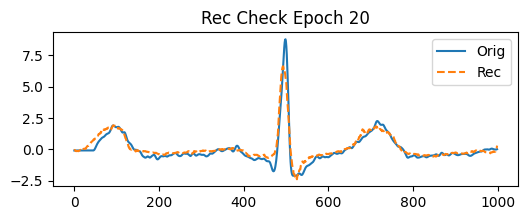

Epoch 021/200 [PRE ] | Trn: L=0.1777 (R=0.1777 C=0.7235) F1=0.5006) | Val: L=0.1585 (R=0.1585 C=0.7158 F1=0.4839)
Epoch 022/200 [PRE ] | Trn: L=0.1746 (R=0.1746 C=0.7259) F1=0.4900) | Val: L=0.1529 (R=0.1529 C=0.7162 F1=0.4815)
Epoch 023/200 [PRE ] | Trn: L=0.1738 (R=0.1738 C=0.7279) F1=0.4940) | Val: L=0.1533 (R=0.1533 C=0.7163 F1=0.4833)
Epoch 024/200 [PRE ] | Trn: L=0.1666 (R=0.1666 C=0.7247) F1=0.4930) | Val: L=0.1500 (R=0.1500 C=0.7167 F1=0.4842)
Epoch 025/200 [PRE ] | Trn: L=0.1643 (R=0.1643 C=0.7261) F1=0.4955) | Val: L=0.1461 (R=0.1461 C=0.7165 F1=0.4863)
Epoch 026/200 [PRE ] | Trn: L=0.1620 (R=0.1620 C=0.7254) F1=0.4954) | Val: L=0.1483 (R=0.1483 C=0.7159 F1=0.4840)
Epoch 027/200 [PRE ] | Trn: L=0.1624 (R=0.1624 C=0.7285) F1=0.4920) | Val: L=0.1450 (R=0.1450 C=0.7168 F1=0.4831)
Epoch 028/200 [PRE ] | Trn: L=0.1576 (R=0.1576 C=0.7255) F1=0.4925) | Val: L=0.1467 (R=0.1467 C=0.7166 F1=0.4868)
Epoch 029/200 [PRE ] | Trn: L=0.1556 (R=0.1556 C=0.7252) F1=0.4927) | Val: L=0.1426 (R=0

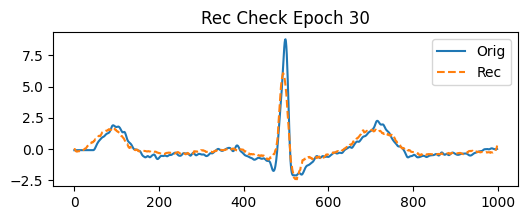

Epoch 031/200 [PRE ] | Trn: L=0.1519 (R=0.1519 C=0.7267) F1=0.4933) | Val: L=0.1427 (R=0.1427 C=0.7159 F1=0.4831)
Epoch 032/200 [PRE ] | Trn: L=0.1496 (R=0.1496 C=0.7283) F1=0.4857) | Val: L=0.1420 (R=0.1420 C=0.7155 F1=0.4864)
Epoch 033/200 [PRE ] | Trn: L=0.1495 (R=0.1495 C=0.7249) F1=0.4922) | Val: L=0.1387 (R=0.1387 C=0.7167 F1=0.4836)
Epoch 034/200 [PRE ] | Trn: L=0.1471 (R=0.1471 C=0.7255) F1=0.4986) | Val: L=0.1414 (R=0.1414 C=0.7157 F1=0.4835)
Epoch 035/200 [PRE ] | Trn: L=0.1470 (R=0.1470 C=0.7219) F1=0.5018) | Val: L=0.1394 (R=0.1394 C=0.7170 F1=0.4795)
Epoch 036/200 [PRE ] | Trn: L=0.1436 (R=0.1436 C=0.7291) F1=0.4911) | Val: L=0.1374 (R=0.1374 C=0.7160 F1=0.4772)
Epoch 037/200 [PRE ] | Trn: L=0.1424 (R=0.1424 C=0.7265) F1=0.4952) | Val: L=0.1377 (R=0.1377 C=0.7164 F1=0.4773)
Epoch 038/200 [PRE ] | Trn: L=0.1429 (R=0.1429 C=0.7266) F1=0.4931) | Val: L=0.1454 (R=0.1454 C=0.7162 F1=0.4735)
Epoch 039/200 [PRE ] | Trn: L=0.1439 (R=0.1439 C=0.7239) F1=0.5001) | Val: L=0.1349 (R=0

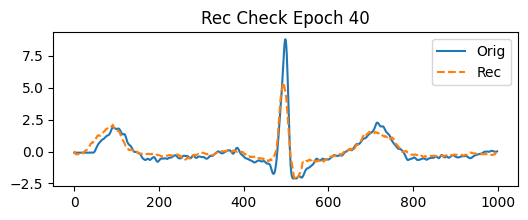

Epoch 041/200 [PRE ] | Trn: L=0.1371 (R=0.1371 C=0.7254) F1=0.4956) | Val: L=0.1357 (R=0.1357 C=0.7155 F1=0.4789)
Epoch 042/200 [PRE ] | Trn: L=0.1382 (R=0.1382 C=0.7255) F1=0.4931) | Val: L=0.1375 (R=0.1375 C=0.7163 F1=0.4783)
Epoch 043/200 [PRE ] | Trn: L=0.1347 (R=0.1347 C=0.7269) F1=0.4868) | Val: L=0.1378 (R=0.1378 C=0.7150 F1=0.4812)
Epoch 044/200 [PRE ] | Trn: L=0.1357 (R=0.1357 C=0.7254) F1=0.4995) | Val: L=0.1357 (R=0.1357 C=0.7159 F1=0.4798)
--> Phase 1 Early Stopping triggered at epoch 44. Best Rec: 0.13491

>>> SWITCHING TO FINE-TUNING PHASE (Epoch 45): Reducing LR to 5e-05 <<<
>>> Loaded best reconstruction model for fine-tuning.
Epoch 045/200 [FINE] | Trn: L=0.3154 (R=0.1323 C=0.7223) F1=0.5044) | Val: L=0.3121 (R=0.1325 C=0.7141 F1=0.4826)
 -> New Best F1: 0.4826 (Saved)
Epoch 046/200 [FINE] | Trn: L=0.3136 (R=0.1295 C=0.7192) F1=0.4986) | Val: L=0.3112 (R=0.1313 C=0.7122 F1=0.4852)
 -> New Best F1: 0.4852 (Saved)
Epoch 047/200 [FINE] | Trn: L=0.3117 (R=0.1299 C=0.7144) 

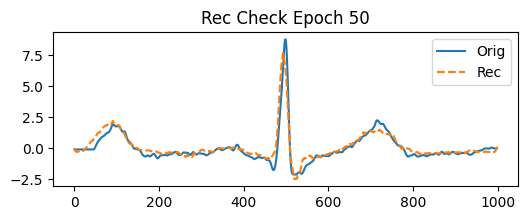

Epoch 051/200 [FINE] | Trn: L=0.3088 (R=0.1291 C=0.7075) F1=0.5062) | Val: L=0.3097 (R=0.1320 C=0.7082 F1=0.5162)
 -> New Best F1: 0.5162 (Saved)
Epoch 052/200 [FINE] | Trn: L=0.3077 (R=0.1297 C=0.7044) F1=0.5140) | Val: L=0.3097 (R=0.1331 C=0.7076 F1=0.5193)
 -> New Best F1: 0.5193 (Saved)
Epoch 053/200 [FINE] | Trn: L=0.3068 (R=0.1304 C=0.7017) F1=0.5245) | Val: L=0.3096 (R=0.1328 C=0.7075 F1=0.5196)
 -> New Best F1: 0.5196 (Saved)
Epoch 054/200 [FINE] | Trn: L=0.3060 (R=0.1318 C=0.6990) F1=0.5313) | Val: L=0.3091 (R=0.1340 C=0.7057 F1=0.5315)
 -> New Best F1: 0.5315 (Saved)
Epoch 055/200 [FINE] | Trn: L=0.3057 (R=0.1325 C=0.6979) F1=0.5424) | Val: L=0.3090 (R=0.1365 C=0.7042 F1=0.5401)
 -> New Best F1: 0.5401 (Saved)
Epoch 056/200 [FINE] | Trn: L=0.3036 (R=0.1338 C=0.6921) F1=0.5477) | Val: L=0.3094 (R=0.1370 C=0.7050 F1=0.5315)
Epoch 057/200 [FINE] | Trn: L=0.3040 (R=0.1357 C=0.6922) F1=0.5565) | Val: L=0.3087 (R=0.1384 C=0.7025 F1=0.5408)
 -> New Best F1: 0.5408 (Saved)
Epoch 058/

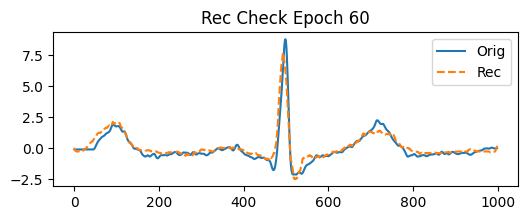

Epoch 061/200 [FINE] | Trn: L=0.2972 (R=0.1431 C=0.6715) F1=0.5949) | Val: L=0.3067 (R=0.1467 C=0.6935 F1=0.5631)
 -> New Best F1: 0.5631 (Saved)
Epoch 062/200 [FINE] | Trn: L=0.2930 (R=0.1459 C=0.6596) F1=0.6092) | Val: L=0.3067 (R=0.1508 C=0.6913 F1=0.5707)
 -> New Best F1: 0.5707 (Saved)
Epoch 063/200 [FINE] | Trn: L=0.2906 (R=0.1489 C=0.6520) F1=0.6234) | Val: L=0.3040 (R=0.1523 C=0.6840 F1=0.5765)
 -> New Best F1: 0.5765 (Saved)
Epoch 064/200 [FINE] | Trn: L=0.2883 (R=0.1518 C=0.6447) F1=0.6421) | Val: L=0.3031 (R=0.1560 C=0.6797 F1=0.5794)
 -> New Best F1: 0.5794 (Saved)
Epoch 065/200 [FINE] | Trn: L=0.2845 (R=0.1538 C=0.6344) F1=0.6578) | Val: L=0.3026 (R=0.1559 C=0.6786 F1=0.5881)
 -> New Best F1: 0.5881 (Saved)
Epoch 066/200 [FINE] | Trn: L=0.2802 (R=0.1547 C=0.6232) F1=0.6702) | Val: L=0.3002 (R=0.1584 C=0.6712 F1=0.6001)
 -> New Best F1: 0.6001 (Saved)
Epoch 067/200 [FINE] | Trn: L=0.2786 (R=0.1571 C=0.6181) F1=0.6818) | Val: L=0.3019 (R=0.1592 C=0.6751 F1=0.5945)
Epoch 068/

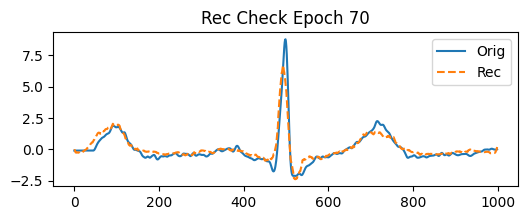

Epoch 071/200 [FINE] | Trn: L=0.2649 (R=0.1597 C=0.5825) F1=0.7149) | Val: L=0.3002 (R=0.1610 C=0.6699 F1=0.6329)
 -> New Best F1: 0.6329 (Saved)
Epoch 072/200 [FINE] | Trn: L=0.2633 (R=0.1596 C=0.5784) F1=0.7211) | Val: L=0.2986 (R=0.1601 C=0.6665 F1=0.6225)
Epoch 073/200 [FINE] | Trn: L=0.2582 (R=0.1589 C=0.5660) F1=0.7296) | Val: L=0.2984 (R=0.1599 C=0.6662 F1=0.6350)
 -> New Best F1: 0.6350 (Saved)
Epoch 074/200 [FINE] | Trn: L=0.2548 (R=0.1592 C=0.5575) F1=0.7386) | Val: L=0.2981 (R=0.1615 C=0.6646 F1=0.6283)
Epoch 075/200 [FINE] | Trn: L=0.2554 (R=0.1599 C=0.5585) F1=0.7356) | Val: L=0.3005 (R=0.1630 C=0.6698 F1=0.6389)
 -> New Best F1: 0.6389 (Saved)
Epoch 076/200 [FINE] | Trn: L=0.2505 (R=0.1596 C=0.5464) F1=0.7491) | Val: L=0.3004 (R=0.1627 C=0.6695 F1=0.6457)
 -> New Best F1: 0.6457 (Saved)
Epoch 077/200 [FINE] | Trn: L=0.2492 (R=0.1601 C=0.5429) F1=0.7546) | Val: L=0.3000 (R=0.1646 C=0.6678 F1=0.6473)
 -> New Best F1: 0.6473 (Saved)
Epoch 078/200 [FINE] | Trn: L=0.2466 (R=0.

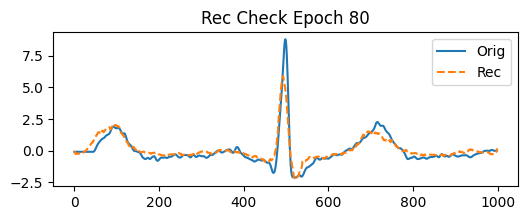

Epoch 081/200 [FINE] | Trn: L=0.2391 (R=0.1599 C=0.5178) F1=0.7752) | Val: L=0.3044 (R=0.1657 C=0.6781 F1=0.6496)
Epoch 082/200 [FINE] | Trn: L=0.2368 (R=0.1609 C=0.5116) F1=0.7796) | Val: L=0.3070 (R=0.1659 C=0.6847 F1=0.6486)
Epoch 083/200 [FINE] | Trn: L=0.2359 (R=0.1617 C=0.5088) F1=0.7848) | Val: L=0.3082 (R=0.1680 C=0.6865 F1=0.6489)
Epoch 084/200 [FINE] | Trn: L=0.2329 (R=0.1626 C=0.5010) F1=0.7919) | Val: L=0.3083 (R=0.1683 C=0.6867 F1=0.6426)
Epoch 085/200 [FINE] | Trn: L=0.2295 (R=0.1623 C=0.4926) F1=0.8007) | Val: L=0.3090 (R=0.1693 C=0.6879 F1=0.6514)
 -> New Best F1: 0.6514 (Saved)
Epoch 086/200 [FINE] | Trn: L=0.2281 (R=0.1624 C=0.4890) F1=0.8007) | Val: L=0.3101 (R=0.1695 C=0.6904 F1=0.6524)
 -> New Best F1: 0.6524 (Saved)
Epoch 087/200 [FINE] | Trn: L=0.2253 (R=0.1627 C=0.4819) F1=0.8063) | Val: L=0.3126 (R=0.1694 C=0.6969 F1=0.6495)
Epoch 088/200 [FINE] | Trn: L=0.2241 (R=0.1634 C=0.4785) F1=0.8141) | Val: L=0.3152 (R=0.1712 C=0.7023 F1=0.6483)
Epoch 089/200 [FINE] | T

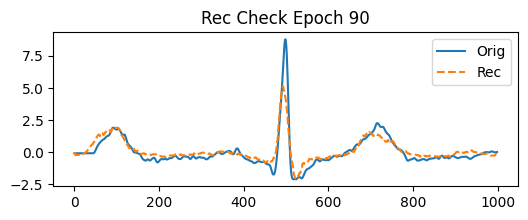

Epoch 091/200 [FINE] | Trn: L=0.2185 (R=0.1653 C=0.4637) F1=0.8253) | Val: L=0.3201 (R=0.1708 C=0.7149 F1=0.6347)
Epoch 092/200 [FINE] | Trn: L=0.2158 (R=0.1644 C=0.4574) F1=0.8286) | Val: L=0.3205 (R=0.1736 C=0.7145 F1=0.6349)
Epoch 093/200 [FINE] | Trn: L=0.2136 (R=0.1660 C=0.4509) F1=0.8371) | Val: L=0.3216 (R=0.1739 C=0.7169 F1=0.6319)
Epoch 094/200 [FINE] | Trn: L=0.2126 (R=0.1660 C=0.4485) F1=0.8349) | Val: L=0.3236 (R=0.1734 C=0.7222 F1=0.6372)
Epoch 095/200 [FINE] | Trn: L=0.2111 (R=0.1660 C=0.4448) F1=0.8392) | Val: L=0.3291 (R=0.1752 C=0.7352 F1=0.6305)
Epoch 096/200 [FINE] | Trn: L=0.2101 (R=0.1664 C=0.4420) F1=0.8448) | Val: L=0.3302 (R=0.1755 C=0.7378 F1=0.6342)
Epoch 097/200 [FINE] | Trn: L=0.2068 (R=0.1668 C=0.4336) F1=0.8543) | Val: L=0.3289 (R=0.1761 C=0.7341 F1=0.6360)
Epoch 098/200 [FINE] | Trn: L=0.2040 (R=0.1659 C=0.4269) F1=0.8622) | Val: L=0.3341 (R=0.1775 C=0.7466 F1=0.6343)
Epoch 099/200 [FINE] | Trn: L=0.2022 (R=0.1655 C=0.4226) F1=0.8585) | Val: L=0.3344 (R=0

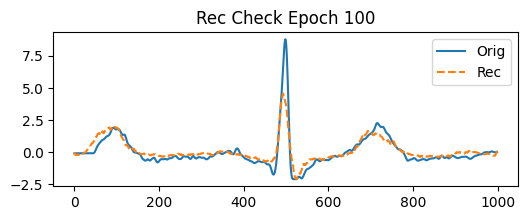

Epoch 101/200 [FINE] | Trn: L=0.1993 (R=0.1661 C=0.4151) F1=0.8673) | Val: L=0.3319 (R=0.1762 C=0.7416 F1=0.6401)
Epoch 102/200 [FINE] | Trn: L=0.1981 (R=0.1658 C=0.4123) F1=0.8726) | Val: L=0.3360 (R=0.1776 C=0.7513 F1=0.6255)
Epoch 103/200 [FINE] | Trn: L=0.1958 (R=0.1654 C=0.4069) F1=0.8727) | Val: L=0.3438 (R=0.1772 C=0.7708 F1=0.6267)
Epoch 104/200 [FINE] | Trn: L=0.1960 (R=0.1668 C=0.4066) F1=0.8749) | Val: L=0.3412 (R=0.1776 C=0.7641 F1=0.6291)
Epoch 105/200 [FINE] | Trn: L=0.1930 (R=0.1667 C=0.3992) F1=0.8790) | Val: L=0.3471 (R=0.1807 C=0.7775 F1=0.6288)
--> Phase 2 Early Stopping at epoch 105. Best F1: 0.6542


In [15]:
# ==== CELL 13: Training Loop with Pre-training, Early Stopping (Rec & F1) ==


# --- Class Balancing ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_win), y=y_train_win.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion_cls = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
criterion_rec = nn.MSELoss()

# --- Optimizer ---
optimizer = optim.Adam(model.parameters(), lr=LR_INITIAL, weight_decay=1e-5)

current_pretrain_epochs = PRETRAIN_EPOCHS # Will be updated if early stopping triggers

# --- Early Stopping Config ---
trigger_rec = 0
best_val_rec = float('inf')
trigger_f1 = 0
best_f1_val = -1.0

train_losses, val_losses = [], []
train_f1s, val_f1s = [], []

print("Starting training...")
print(f"Phase 1: Pre-training (Rec Only) max {PRETRAIN_EPOCHS} epochs.")
print(f"Phase 2: Fine-tuning (Rec + Cls) starts automatically after Phase 1.")

for epoch in range(NUM_EPOCHS):
    # Determine Phase dynamically
    is_pretrain = epoch < current_pretrain_epochs

    # --- SWITCH LOGIC: Reduce LR when entering Fine-Tuning Phase ---
    if epoch == current_pretrain_epochs:
        print(f"\n>>> SWITCHING TO FINE-TUNING PHASE (Epoch {epoch+1}): Reducing LR to {LR_FINE} <<<")
        # Load best reconstruction weights to start fine-tuning from the best point
        try:
            model.load_state_dict(torch.load("best_rec_only.pth"))
            print(">>> Loaded best reconstruction model for fine-tuning.")
        except:
            pass

        for param_group in optimizer.param_groups:
            param_group['lr'] = LR_FINE

    # --- TRAIN ---
    model.train()
    running_loss, running_rec, running_cls = 0.0, 0.0, 0.0
    all_preds, all_labels = [], []

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        x_hat, z_cat, logits = model(x_batch)

        loss_rec = criterion_rec(x_hat, x_batch)
        loss_cls = criterion_cls(logits, y_batch)

        if is_pretrain:
            loss_total = loss_rec
        else:
            loss_total = ALPHA * loss_rec + BETA * loss_cls

        loss_total.backward()
        optimizer.step()

        running_loss += loss_total.item()
        running_rec  += loss_rec.item()
        running_cls  += loss_cls.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    avg_train_rec  = running_rec  / len(train_loader)
    avg_train_cls  = running_cls  / len(train_loader)
    f1_train = f1_score(all_labels, all_preds, average="macro")

    # --- VAL ---
    model.eval()
    val_loss, val_rec, val_cls = 0.0, 0.0, 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            x_hat_val, z_cat_val, logits_val = model(x_val)

            l_rec = criterion_rec(x_hat_val, x_val)
            l_cls = criterion_cls(logits_val, y_val)

            if is_pretrain:
                l_tot = l_rec
            else:
                l_tot = ALPHA * l_rec + BETA * l_cls

            val_loss += l_tot.item()
            val_rec  += l_rec.item()
            val_cls  += l_cls.item()

            preds_val = torch.argmax(logits_val, dim=1)
            val_preds.extend(preds_val.cpu().numpy())
            val_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    avg_val_rec  = val_rec  / len(val_loader)
    avg_val_cls  = val_cls  / len(val_loader)
    f1_val = f1_score(val_labels, val_preds, average="macro")

    phase_str = "PRE " if is_pretrain else "FINE"

    # Print Metrics
    print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} [{phase_str}] | "
          f"Trn: L={avg_train_loss:.4f} (R={avg_train_rec:.4f} C={avg_train_cls:.4f}) F1={f1_train:.4f}) | "
          f"Val: L={avg_val_loss:.4f} (R={avg_val_rec:.4f} C={avg_val_cls:.4f} F1={f1_val:.4f})")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_f1s.append(f1_train)
    val_f1s.append(f1_val)

    # --- EARLY STOPPING LOGIC ---

    if is_pretrain:
        # Phase 1 Strategy: Minimize Reconstruction Loss
        if avg_val_rec < best_val_rec:
            best_val_rec = avg_val_rec
            torch.save(model.state_dict(), "best_rec_only.pth")
            trigger_rec = 0
        else:
            trigger_rec += 1
            if trigger_rec >= PATIENCE_REC:
                print(f"--> Phase 1 Early Stopping triggered at epoch {epoch+1}. Best Rec: {best_val_rec:.5f}")
                # Force switch to Fine-tuning in the NEXT loop iteration
                current_pretrain_epochs = epoch + 1

    else:
        # Phase 2 Strategy: Maximize F1 Score
        if f1_val > best_f1_val:
            best_f1_val = f1_val
            torch.save(model.state_dict(), "best_ae_split_leads.pth")
            print(f" -> New Best F1: {best_f1_val:.4f} (Saved)")
            trigger_f1 = 0
        else:
            trigger_f1 += 1
            if trigger_f1 >= PATIENCE_F1:
                print(f"--> Phase 2 Early Stopping at epoch {epoch+1}. Best F1: {best_f1_val:.4f}")
                break

    # --- VISUALIZATION (Every 10 epochs) ---
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            x_vis, _ = next(iter(val_loader))
            x_vis = x_vis.to(device)
            x_hat_vis, _, _ = model(x_vis)
            x_vis = x_vis.cpu().numpy()
            x_hat_vis = x_hat_vis.cpu().numpy()

            # Simple check plot
            plt.figure(figsize=(6, 2))
            plt.plot(x_vis[0, 0, :], label="Orig")
            plt.plot(x_hat_vis[0, 0, :], linestyle="--", label="Rec")
            plt.title(f"Rec Check Epoch {epoch+1}")
            plt.legend()
            plt.show()


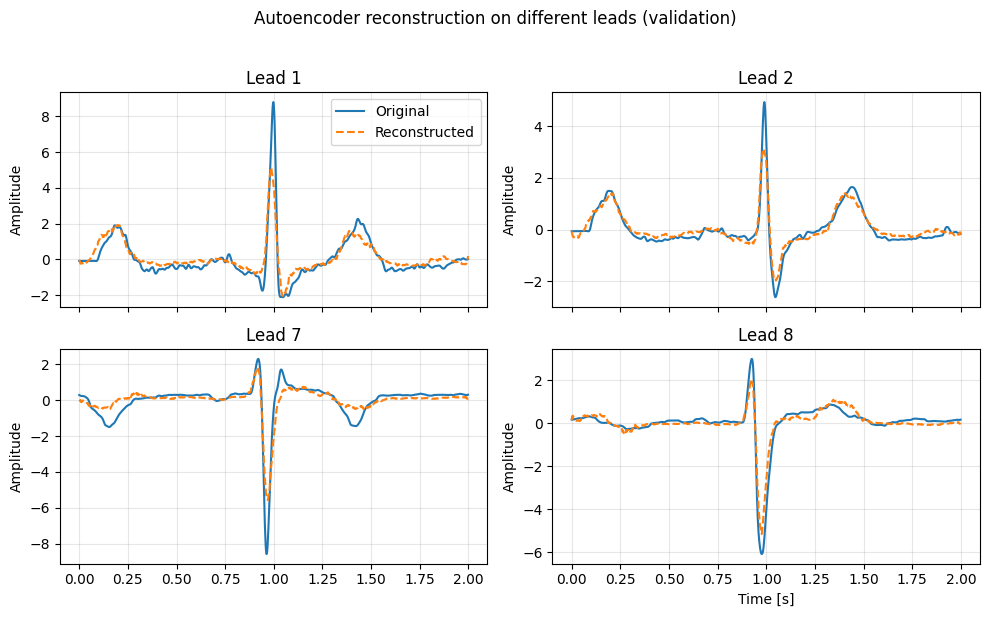

In [44]:
# ==== EXTRA E: Multi-lead reconstruction on validation window ==============
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    x_batch, y_batch = next(iter(val_loader))
    x_batch = x_batch.to(device)
    x_hat_batch, _, _ = model(x_batch)

# Original and reconstructed signals for the first sample in the batch
x_orig = x_batch.cpu().numpy()[0]      # shape: [12, T]
x_rec  = x_hat_batch.cpu().numpy()[0]  # shape: [12, T]

# Time axis in seconds
t = np.arange(x_orig.shape[1]) / FS_SIGNAL

# Select 4 leads to visualize (2 from left side, 2 from right side)
leads_to_plot = [0, 1, 6, 7]

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
axes = axes.flatten()

for ax, lead_idx in zip(axes, leads_to_plot):
    ax.plot(t, x_orig[lead_idx, :], label="Original")
    ax.plot(t, x_rec[lead_idx, :], "--", label="Reconstructed")
    ax.set_title(f"Lead {lead_idx+1}")
    ax.set_ylabel("Amplitude")
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Time [s]")
axes[0].legend()

plt.suptitle("Autoencoder reconstruction on different leads (validation)", y=1.02)
plt.tight_layout()
plt.show()


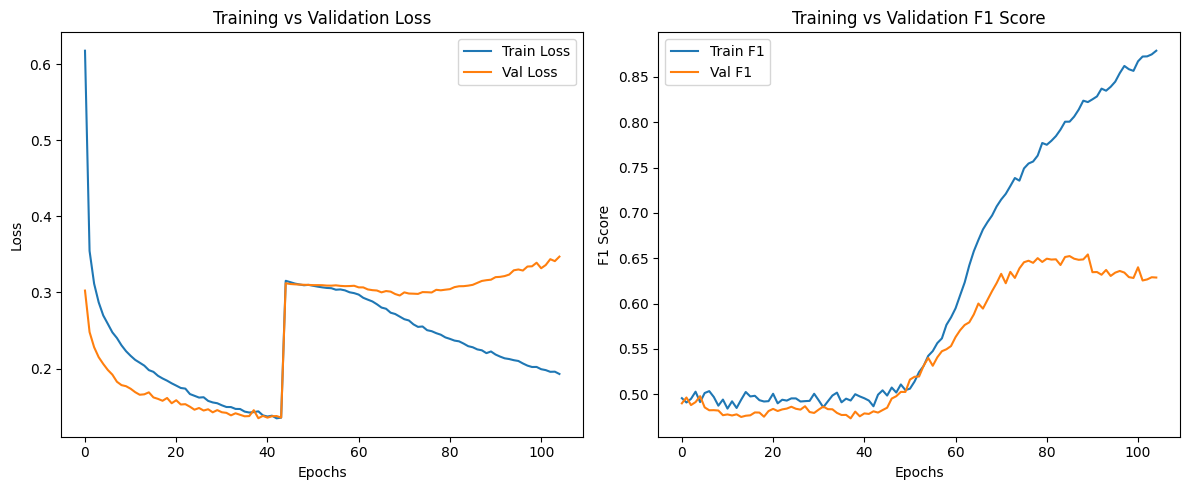

In [17]:
# ==== CELL 14: Plot Metrics =================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label="Train F1")
plt.plot(val_f1s, label="Val F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training vs Validation F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


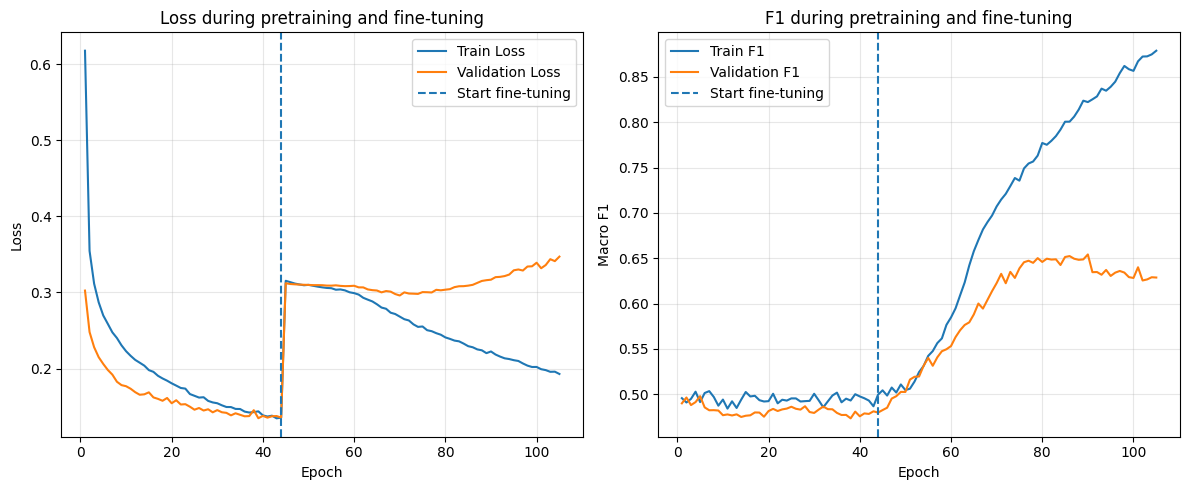

In [45]:
# ==== EXTRA F: Metrics with highlighted phase switch ========================
import matplotlib.pyplot as plt

# Epoch corresponding to the phase switch (start of fine-tuning)
phase_switch_epoch = min(current_pretrain_epochs, len(train_losses))

epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.axvline(phase_switch_epoch, linestyle="--", label="Start fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during pretraining and fine-tuning")
plt.legend()
plt.grid(alpha=0.3)

# F1 curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Validation F1")
plt.axvline(phase_switch_epoch, linestyle="--", label="Start fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.title("F1 during pretraining and fine-tuning")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Latent Feature Extraction and Patient Aggregation
Post-training, the encoder projects all ECG windows into the low-dimensional latent space ($Z$).


In [19]:
# ==== CELL 11: Feature Extraction ===========================================
def get_latent_features(loader, model):
    model.eval()
    Z_list, Y_list, P_list = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, z, _ = model(x)
            Z_list.append(z.cpu().numpy())
            Y_list.append(y.numpy())
            # Note: DataLoader doesn't return PIDs unless we modify it.
            # But we have pid_train, pid_val, pid_test aligned with the datasets.
            # We will handle PIDs separately.

    Z = np.concatenate(Z_list, axis=0)
    Y = np.concatenate(Y_list, axis=0)
    return Z, Y

# Load best model
state_dict = torch.load("/content/best_ae_split_leads.pth", map_location = device)
model.load_state_dict(state_dict)

Z_train, Y_train = get_latent_features(train_loader, model)
Z_val,   Y_val   = get_latent_features(val_loader, model)
Z_test,  Y_test  = get_latent_features(test_loader, model)

train_loader_noshuffle = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
Z_train, Y_train = get_latent_features(train_loader_noshuffle, model)

# Now Z_train corresponds to x_train_norm which corresponds to pid_train
P_train = pid_train.numpy()
P_val   = pid_val.numpy()
P_test  = pid_test.numpy()

print("Z_train shape:", Z_train.shape)
print("Z_test shape: ", Z_test.shape)

Z_trainval = np.concatenate([Z_train, Z_val], axis=0)
Y_trainval = np.concatenate([Y_train, Y_val], axis=0)
P_trainval = np.concatenate([P_train, P_val], axis=0)  # se vuoi tenere traccia dei PID

print("Z_train shape:", Z_trainval.shape)
print("Z_test shape: ", Z_test.shape)

Z_train shape: (5712, 32)
Z_test shape:  (1802, 32)
Z_train shape: (7140, 32)
Z_test shape:  (1802, 32)


In [20]:
# ==== CELL 12: Patient-Level RF (Mean+Std Z) ===============================
def aggregate_features(Z, P, Y):
    df = pd.DataFrame(Z)
    df["pid"] = P
    df["label"] = Y
    # Group by PID
    grouped = df.groupby("pid")

    # Mean and Std of features
    feat_mean = grouped.mean().drop(columns=["label"])
    feat_std  = grouped.std().drop(columns=["label"])

    # Combine
    X_agg = pd.concat([feat_mean, feat_std], axis=1).values
    y_agg = grouped["label"].first().values

    return X_agg, y_agg

# Use Balanced Training Set for Aggregation
X_train_agg, y_train_agg = aggregate_features(Z_trainval, P_trainval, Y_trainval)
X_test_agg,  y_test_agg  = aggregate_features(Z_test,  P_test,  Y_test)

In [21]:
print(X_train_agg.shape)
print(y_train_agg.shape)
print(X_test_agg.shape)
print(y_test_agg.shape)

(420, 64)
(420,)
(106, 64)
(106,)


## 7. Tabular Features

If clinical or derived tabular features are available, we can combine them with latent features.

**Steps**
- Clean and align rows by patient ID
- Handle missing values (simple imputation)
- Scale features (important for linear models and SVM)
- Merge with latent-derived patient features

**Goal**
Test whether latent features alone are enough, or if tabular data adds signal.


In [23]:
# ==== CELL A: Tabular Data Preprocessing ====================================

def prepare_tabular_data(df_full):
      # 1. Copia per non modificare l'originale
    df = df_full.copy()

    # 2. Definizione Colonne Patologie da Eliminare
    pathology_cols = [
        "AV block", "ST abnormality", "Complete BBB", "Prolonged QTc",
        "Uncontrolled hypertension", "Supraventricular arrhythmias",
        "Ventricular arrhythmias", "Baseline ECG abnormalities",
        "Valvular heart diseases", "Symptomatic patients"
    ]

    # Eliminiamo solo le colonne di patologie che esistono nel DataFrame
    existing_pathology_cols = [c for c in pathology_cols if c in df.columns]
    df = df.drop(columns=existing_pathology_cols)

    # 3. Riempimento dei valori NaN di 'height' e 'weight' con la mediana per sesso
    df['height'] = df.groupby('sex')['height'].transform(lambda x: x.fillna(x.median()))
    df['weight'] = df.groupby('sex')['weight'].transform(lambda x: x.fillna(x.median()))


    if 'trainning_load' in df.columns:
       mode_value = df['trainning_load'].mode()[0]
       df['trainning_load'] = df['trainning_load'].fillna(mode_value)
    else:
      print("Warning: Column 'trainning_load' not found. Check spelling!")

    # 4. Imposta ECG_patient_id come indice per facilitare il merge
    if "ECG_patient_id" in df.columns:
        df = df.set_index("ECG_patient_id")

    # 5. Selezioniamo solo le feature tabellari rimaste utili
    # Escludiamo 'sport_ability' perché è il target (y), non una feature (X)
    feature_cols = ["age_at_exam", "sex","weight", "height", "trainning_load", "sport_classification"]
    # Filtriamo solo quelle presenti
    valid_features = [c for c in feature_cols if c in df.columns]

    print(f"Final Tabular Features selected: {valid_features}")
    return df[valid_features]

# Eseguiamo il preprocessing
# Assumiamo che 'tabular_data' sia il tuo dataframe originale caricato dall'Excel
tabular_features_df = prepare_tabular_data(tabular_data)

Final Tabular Features selected: ['age_at_exam', 'sex', 'weight', 'height', 'trainning_load', 'sport_classification']


In [24]:
tabular_features_df.head()

,age_at_exam,sex,weight,height,trainning_load,sport_classification
ECG_patient_id,,,,,,
3,20.095825,0,60.0,166.0,2.0,1
4,51.646817,0,84.0,180.0,2.0,1
5,40.936345,0,104.0,180.0,1.0,1
6,14.201232,0,80.0,174.0,2.0,1
7,16.607803,1,47.0,148.0,2.0,1


In [25]:
# ==== CELL B: Feature Aggregation & Merging (AE + Tabular) ==================

def aggregate_and_merge(Z, P, Y, tabular_df):
    """
    1. Aggrega le feature Latenti (Z) per paziente (Mean + Std).
    2. Unisce le feature Tabellari corrispondenti.
    """
    # --- 1. Aggregazione Latente ---
    df_ae = pd.DataFrame(Z)
    df_ae["pid"] = P
    # Nota: Non mettiamo "label" qui per ora, la gestiamo dopo

    grouped = df_ae.groupby("pid")
    feat_mean = grouped.mean()
    feat_std  = grouped.std()

    # Rinomina colonne per chiarezza
    feat_mean.columns = [f"z_mean_{i}" for i in range(feat_mean.shape[1])]
    feat_std.columns  = [f"z_std_{i}"  for i in range(feat_std.shape[1])]

    # Uniamo Mean e Std
    df_ae_agg = pd.concat([feat_mean, feat_std], axis=1)

    # --- 2. Merge con Tabulare ---
    # Uniamo usando l'indice (PID)
    # inner join: teniamo solo i pazienti che hanno SIA l'ECG SIA i dati tabellari puliti
    df_combined = df_ae_agg.merge(tabular_df, left_index=True, right_index=True, how='inner')

    # Recuperiamo le label corrette per i pazienti rimasti
    # (Usiamo Y originale mappato sui PID, facendo attenzione all'ordine)
    # Creiamo un dizionario PID -> Label veloce
    pid_to_label = dict(zip(P, Y))

    # Estraiamo le label per i PID che sono sopravvissuti al merge
    y_combined = np.array([pid_to_label[pid] for pid in df_combined.index])

    # Feature Matrix
    X_combined = df_combined.values

    print(f"Data merged: {len(df_ae_agg)} ECG patients -> {len(df_combined)} Combined patients")

    return X_combined, y_combined, df_combined.index.values

# --- Creazione dei nuovi dataset combinati ---
print("--- Merging Train ---")
X_train_full, y_train_full, p_train_full = aggregate_and_merge(Z_train, pid_train.numpy(), y_train_win.numpy(), tabular_features_df)

print("--- Merging Val ---")
X_val_full,   y_val_full,   p_val_full   = aggregate_and_merge(Z_val,   pid_val.numpy(),   y_val_win.numpy(),   tabular_features_df)

print("--- Merging Test ---")
X_test_full,  y_test_full,  p_test_full  = aggregate_and_merge(Z_test,  pid_test.numpy(),  y_test_win.numpy(),  tabular_features_df)

--- Merging Train ---
Data merged: 336 ECG patients -> 336 Combined patients
--- Merging Val ---
Data merged: 84 ECG patients -> 84 Combined patients
--- Merging Test ---
Data merged: 106 ECG patients -> 106 Combined patients


In [46]:
import numpy as np

# Concatenate training and validation sets
X_train_val_full = np.concatenate([X_train_full, X_val_full], axis=0)
y_train_val_full = np.concatenate([y_train_full, y_val_full], axis=0)
p_train_val_full = np.concatenate([p_train_full, p_val_full], axis=0)

print("Shapes after concatenation:")
print("X_train_val_full:", X_train_val_full.shape)
print("y_train_val_full:", y_train_val_full.shape)
print("p_train_val_full:", p_train_val_full.shape)


Shapes after concatenation:
X_train_val_full: (420, 70)
y_train_val_full: (420,)
p_train_val_full: (420,)


## 8. Feature Selection

Feature selection helps reduce noise and overfitting.

**Good practice**
Do feature selection using only the training split.
Then apply the same selected feature set to validation/test.


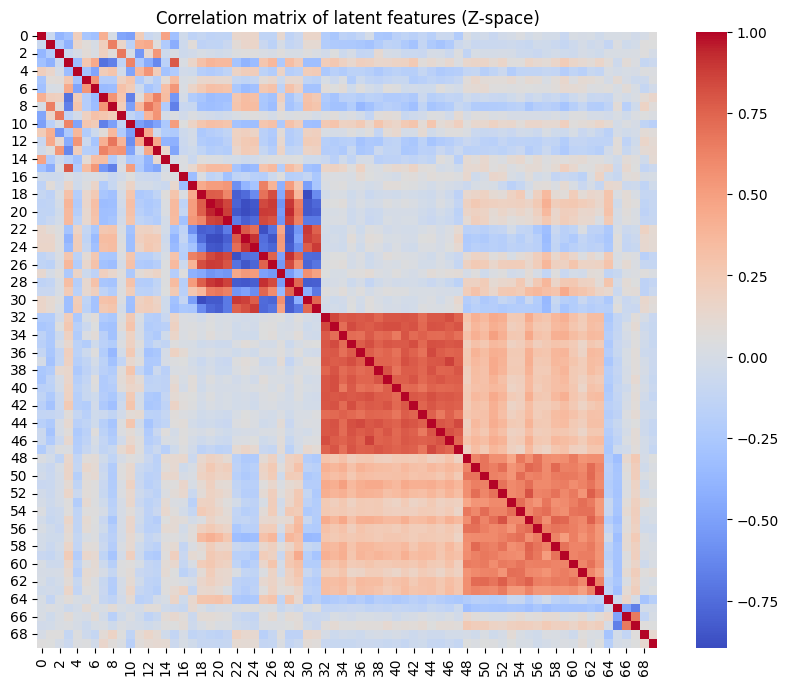

In [27]:
import seaborn as sns

df_Z = pd.DataFrame(X_train_val_full)
corr_matrix = df_Z.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation matrix of latent features (Z-space)")
plt.show()

In [48]:
# Z_train shape: (n_samples, latent_dim)
df_X = pd.DataFrame(X_train_val_full)
df_test = pd.DataFrame(X_test_full)

# 1. Compute absolute correlation matrix
corr_matrix = df_X.corr().abs()

# Upper triangular matrix to avoid duplicate checks
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify highly correlated features
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

print("Features to remove:", to_drop)

# Drop correlated features
X_train_reduced_full = df_X.drop(columns=to_drop).values
X_test_reduced_full = df_test.drop(columns=to_drop).values

print("Original train shape:", X_train_val_full.shape)
print("Reduced train shape:", X_train_reduced_full.shape)

print("Original test shape:", X_test_full.shape)
print("Reduced test shape:", X_test_reduced_full.shape)


Features to remove: [20, 21, 23, 24, 25, 26, 28, 30, 31, 46]
Original train shape: (420, 70)
Reduced train shape: (420, 60)
Original test shape: (106, 70)
Reduced test shape: (106, 60)


In [29]:
feat_names_ae = [f"z_mean_{i}" for i in range(32)] + [f"z_std_{i}" for i in range(32)]
feat_names_tab = list(tabular_features_df.columns)
all_feat_names = feat_names_ae + feat_names_tab

print(all_feat_names)  # stampa tutti i nomi delle colonne, in ordine


['z_mean_0', 'z_mean_1', 'z_mean_2', 'z_mean_3', 'z_mean_4', 'z_mean_5', 'z_mean_6', 'z_mean_7', 'z_mean_8', 'z_mean_9', 'z_mean_10', 'z_mean_11', 'z_mean_12', 'z_mean_13', 'z_mean_14', 'z_mean_15', 'z_mean_16', 'z_mean_17', 'z_mean_18', 'z_mean_19', 'z_mean_20', 'z_mean_21', 'z_mean_22', 'z_mean_23', 'z_mean_24', 'z_mean_25', 'z_mean_26', 'z_mean_27', 'z_mean_28', 'z_mean_29', 'z_mean_30', 'z_mean_31', 'z_std_0', 'z_std_1', 'z_std_2', 'z_std_3', 'z_std_4', 'z_std_5', 'z_std_6', 'z_std_7', 'z_std_8', 'z_std_9', 'z_std_10', 'z_std_11', 'z_std_12', 'z_std_13', 'z_std_14', 'z_std_15', 'z_std_16', 'z_std_17', 'z_std_18', 'z_std_19', 'z_std_20', 'z_std_21', 'z_std_22', 'z_std_23', 'z_std_24', 'z_std_25', 'z_std_26', 'z_std_27', 'z_std_28', 'z_std_29', 'z_std_30', 'z_std_31', 'age_at_exam', 'sex', 'weight', 'height', 'trainning_load', 'sport_classification']


## 9. Latent Space Visualization

We visualize latent representations to check if the encoder learned structure.




In [49]:
# ==== CELL PCA-VIS-1: PCA for visualization (2D / 3D) =======================
from sklearn.decomposition import PCA

# X_train_scaled and X_test_scaled are computed in the RF cell
# They are reused here for PCA visualization

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced_full)
X_test_scaled  = scaler.transform(X_test_reduced_full)

pca_vis = PCA(n_components=3, random_state=42)
X_train_pca_vis = pca_vis.fit_transform(X_train_scaled)
X_test_pca_vis  = pca_vis.transform(X_test_scaled)

print("X_train_pca_vis shape:", X_train_pca_vis.shape)
print("X_test_pca_vis shape:", X_test_pca_vis.shape)
print("Explained variance ratio:", pca_vis.explained_variance_ratio_)
print("Cumulative explained variance:", pca_vis.explained_variance_ratio_.cumsum())


X_train_pca_vis shape: (420, 3)
X_test_pca_vis shape: (106, 3)
Explained variance ratio: [0.28000071 0.12170444 0.10036107]
Cumulative explained variance: [0.28000071 0.40170515 0.50206622]


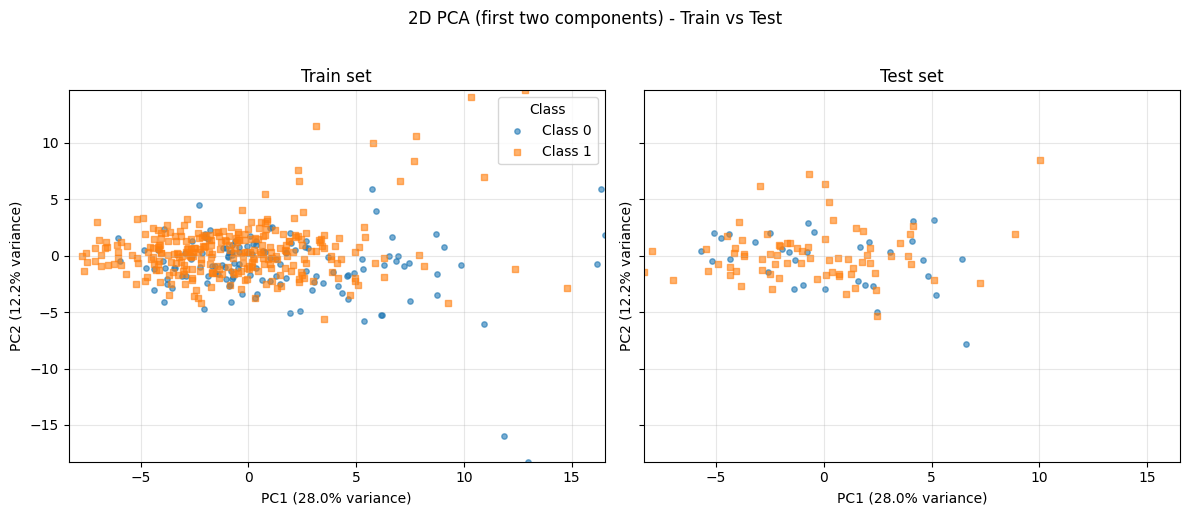

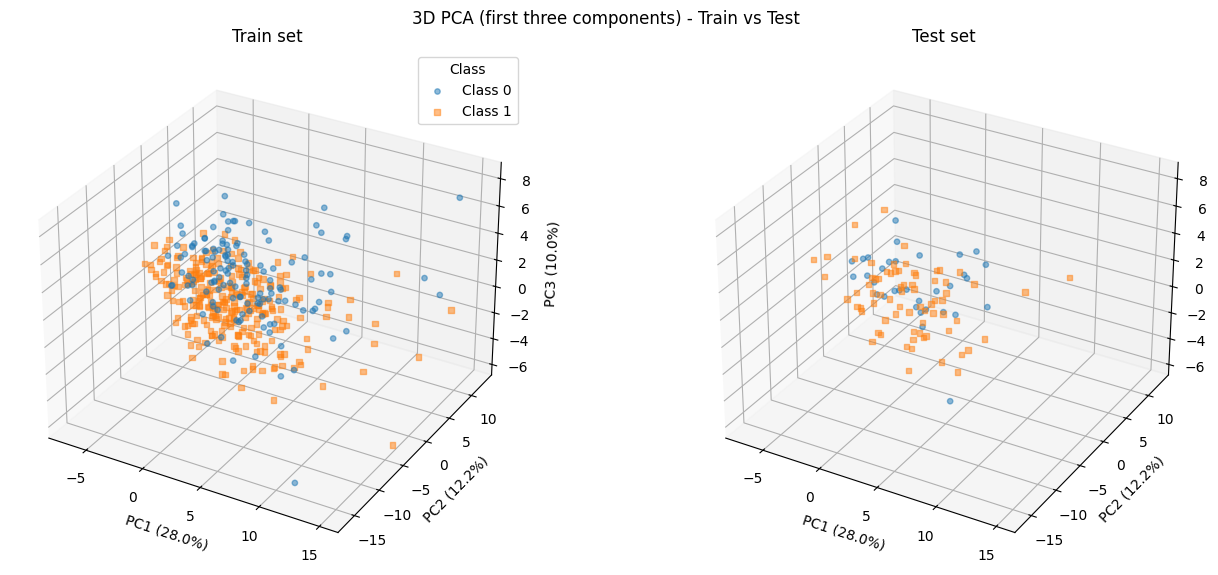

In [50]:
# ==== CELL PCA-VIS-NICE: 2D and 3D PCA plots (Train and Test, aligned axes) ==
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting

# 1) Extract components for plotting
X_train_2d = X_train_pca_vis[:, :2]
X_test_2d  = X_test_pca_vis[:, :2]

X_train_3d = X_train_pca_vis[:, :3]
X_test_3d  = X_test_pca_vis[:, :3]

# 2) Use the same axis limits for train and test
pc1_min = min(X_train_2d[:, 0].min(), X_test_2d[:, 0].min())
pc1_max = max(X_train_2d[:, 0].max(), X_test_2d[:, 0].max())
pc2_min = min(X_train_2d[:, 1].min(), X_test_2d[:, 1].min())
pc2_max = max(X_train_2d[:, 1].max(), X_test_2d[:, 1].max())

pc3_min = min(X_train_3d[:, 2].min(), X_test_3d[:, 2].min())
pc3_max = max(X_train_3d[:, 2].max(), X_test_3d[:, 2].max())

# 3) Explained variance information
var_pc = pca_vis.explained_variance_ratio_
pc1_var, pc2_var, pc3_var = var_pc[0], var_pc[1], var_pc[2]

# ====================== 2D PCA: Train vs Test ===============================
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for ax, X_2d, y, split_name in [
    (axes[0], X_train_2d, y_train_val_full, "Train"),
    (axes[1], X_test_2d,  y_test_full,      "Test")
]:
    for cls, name, marker in [(0, "Class 0", "o"), (1, "Class 1", "s")]:
        idx = (y == cls)
        ax.scatter(
            X_2d[idx, 0],
            X_2d[idx, 1],
            label=name if split_name == "Train" else None,
            alpha=0.6,
            s=15,
            marker=marker
        )
    ax.set_title(f"{split_name} set")
    ax.set_xlabel(f"PC1 ({pc1_var*100:.1f}% variance)")
    ax.set_ylabel(f"PC2 ({pc2_var*100:.1f}% variance)")
    ax.grid(True, alpha=0.3)

fig.suptitle("2D PCA (first two components) - Train vs Test", y=1.02)
axes[0].set_xlim(pc1_min, pc1_max)
axes[0].set_ylim(pc2_min, pc2_max)
axes[0].legend(title="Class")
plt.tight_layout()
plt.show()

# ====================== 3D PCA: Train vs Test ===============================
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")

for ax, X_3d, y, split_name in [
    (ax1, X_train_3d, y_train_val_full, "Train"),
    (ax2, X_test_3d,  y_test_full,      "Test")
]:
    for cls, name, marker in [(0, "Class 0", "o"), (1, "Class 1", "s")]:
        idx = (y == cls)
        ax.scatter(
            X_3d[idx, 0],
            X_3d[idx, 1],
            X_3d[idx, 2],
            label=name if split_name == "Train" else None,
            alpha=0.5,
            s=15,
            marker=marker
        )
    ax.set_title(f"{split_name} set")
    ax.set_xlabel(f"PC1 ({pc1_var*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pc2_var*100:.1f}%)")
    ax.set_zlabel(f"PC3 ({pc3_var*100:.1f}%)")
    ax.set_xlim(pc1_min, pc1_max)
    ax.set_ylim(pc2_min, pc2_max)
    ax.set_zlim(pc3_min, pc3_max)

ax1.legend(title="Class")
fig.suptitle("3D PCA (first three components) - Train vs Test", y=0.95)
plt.tight_layout()
plt.show()


z_train_lda shape: (420, 1)
z_test_lda shape: (106, 1)


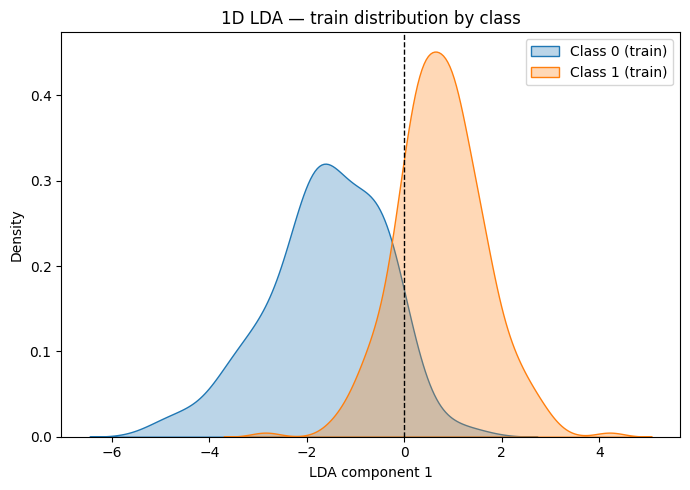

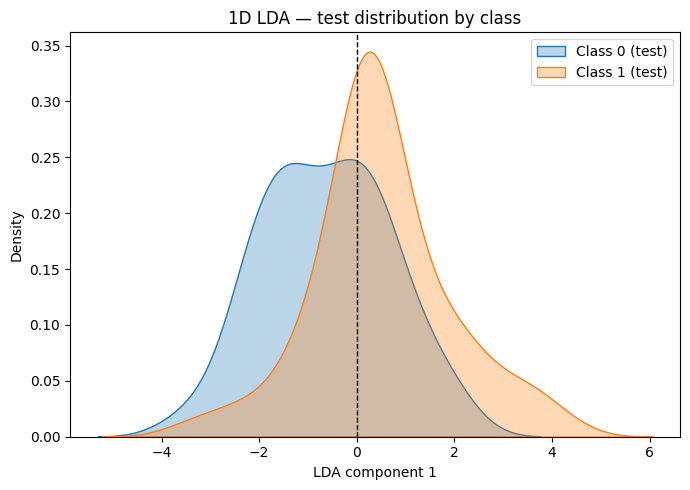

In [51]:
# ==== CELL LDA-1D: Linear Discriminant for class separation =================
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
z_train_lda = lda.fit_transform(X_train_scaled, y_train_val_full)
z_test_lda  = lda.transform(X_test_scaled)

print("z_train_lda shape:", z_train_lda.shape)
print("z_test_lda shape:", z_test_lda.shape)

# 1D plot: distribution along the discriminant direction (train)
plt.figure(figsize=(7, 5))

for cls, color, label in [(0, "tab:blue", "Class 0"), (1, "tab:orange", "Class 1")]:
    idx_tr = (y_train_val_full == cls)
    sns.kdeplot(
        z_train_lda[idx_tr, 0],
        fill=True,
        alpha=0.3,
        common_norm=False,
        color=color,
        label=f"{label} (train)",
    )

plt.axvline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("LDA component 1")
plt.title("1D LDA — train distribution by class")
plt.legend()
plt.tight_layout()
plt.show()

# Same visualization on the test set
plt.figure(figsize=(7, 5))

for cls, color, label in [(0, "tab:blue", "Class 0"), (1, "tab:orange", "Class 1")]:
    idx_te = (y_test_full == cls)
    if idx_te.sum() > 5:
        sns.kdeplot(
            z_test_lda[idx_te, 0],
            fill=True,
            alpha=0.3,
            common_norm=False,
            color=color,
            label=f"{label} (test)",
        )

plt.axvline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("LDA component 1")
plt.title("1D LDA — test distribution by class")
plt.legend()
plt.tight_layout()
plt.show()


## 10. Model Selection on Validation

We compare several classical models trained on patient-level features.
We select the best one using validation metrics.

**Rule**
Validation decides the “winner”.
Test is used only once, at the end.


Train split shape: (336, 60)
Val split shape:   (84, 60)
Test shape:        (106, 60)

=== RF: testing 10 configurations (BASE included) ===
  RF #01 | AUC tr=0.9642 | AUC val=0.9266 | params={'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2, 'max_features': 'sqrt', 'bootstrap': True}
  RF #02 | AUC tr=0.9652 | AUC val=0.9207 | params={'n_estimators': 200, 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 10, 'max_features': 'sqrt', 'bootstrap': True}
  RF #03 | AUC tr=0.9669 | AUC val=0.9207 | params={'n_estimators': 400, 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 10, 'max_features': 'log2', 'bootstrap': True}
  RF #04 | AUC tr=0.9598 | AUC val=0.9272 | params={'n_estimators': 300, 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 10, 'max_features': 'sqrt', 'bootstrap': True}
  RF #05 | AUC tr=0.9656 | AUC val=0.9272 | params={'n_estimators': 500, 'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 10

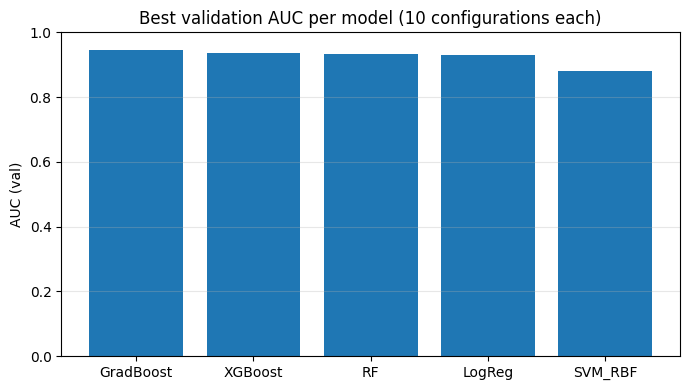

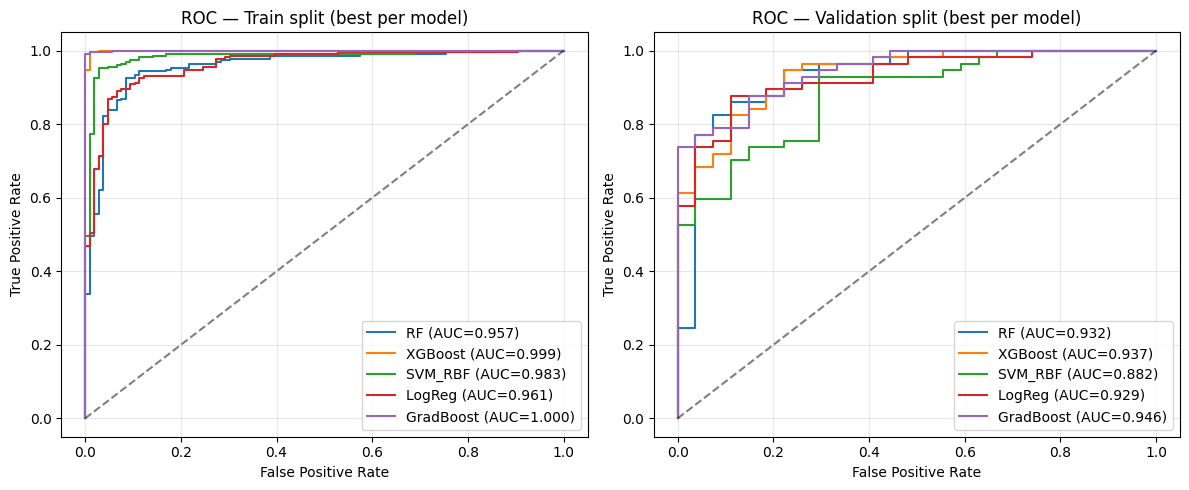


=== SUMMARY (best per model) SORTED BY VALIDATION AUC ===
GradBoost  | AUC Train = 0.9997 | AUC Val = 0.9461
XGBoost    | AUC Train = 0.9994 | AUC Val = 0.9370
RF         | AUC Train = 0.9575 | AUC Val = 0.9324
LogReg     | AUC Train = 0.9612 | AUC Val = 0.9285
SVM_RBF    | AUC Train = 0.9829 | AUC Val = 0.8817

=== MACRO F1 ON VALIDATION (best per model) ===

>>> RF
              precision    recall  f1-score   support

           0     0.7419    0.8519    0.7931        27
           1     0.9245    0.8596    0.8909        57

    accuracy                         0.8571        84
   macro avg     0.8332    0.8558    0.8420        84
weighted avg     0.8658    0.8571    0.8595        84


>>> XGBoost
              precision    recall  f1-score   support

           0     0.8696    0.7407    0.8000        27
           1     0.8852    0.9474    0.9153        57

    accuracy                         0.8810        84
   macro avg     0.8774    0.8441    0.8576        84
weighted avg     

In [53]:
# ==== CELL 1: TRAIN/VAL SPLIT + 10 COMBOS/MODEL (includes BASE) + BEST AUC BAR + ROC ====

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# ------------------- 0. Train/Val split ------------------------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_reduced_full,
    y_train_val_full,
    test_size=0.2,
    stratify=y_train_val_full,
    random_state=42,
)

print("Train split shape:", X_tr.shape)
print("Val split shape:  ", X_val.shape)
print("Test shape:       ", X_test_reduced_full.shape)

# ------------------- 1. Scaling (fit on train only) -------------------------
scaler = StandardScaler()
X_tr_scaled   = scaler.fit_transform(X_tr)
X_val_scaled  = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_reduced_full)

# ------------------- 2. Model factory --------------------------------------
def make_model(name, p):
    if name == "RF":
        return RandomForestClassifier(
            n_jobs=-1, random_state=42,
            class_weight="balanced_subsample",
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_leaf=p["min_samples_leaf"],
            min_samples_split=p["min_samples_split"],
            max_features=p["max_features"],
            bootstrap=p.get("bootstrap", True),
        )

    if name == "XGBoost":
        return XGBClassifier(
            n_jobs=-1, random_state=42, tree_method="hist", eval_metric="logloss",
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            learning_rate=p["learning_rate"],
            subsample=p["subsample"],
            colsample_bytree=p["colsample_bytree"],
            min_child_weight=p["min_child_weight"],
            reg_lambda=p["reg_lambda"],
            reg_alpha=p["reg_alpha"],
        )

    if name == "SVM_RBF":
        return SVC(
            kernel="rbf", probability=True, random_state=42,
            class_weight="balanced",
            C=p["C"],
            gamma=p["gamma"],
        )

    if name == "LogReg":
        return LogisticRegression(
            max_iter=p["max_iter"],
            n_jobs=-1, random_state=42,
            class_weight="balanced",
            C=p["C"],
            penalty=p["penalty"],
            solver=p["solver"],
        )

    if name == "GradBoost":
        return GradientBoostingClassifier(
            random_state=42,
            n_estimators=p["n_estimators"],
            learning_rate=p["learning_rate"],
            max_depth=p["max_depth"],
            min_samples_leaf=p["min_samples_leaf"],
            min_samples_split=p["min_samples_split"],
            subsample=p["subsample"],
        )

    raise ValueError(f"Unknown model: {name}")

# ------------------- 3. 10 combos per model (BASE included) -----------------
# Combo #1 is exactly the configuration you specified. The remaining ones are conservative variations.
param_lists = {
    "RF": [
        dict(n_estimators=300, max_depth=5,  min_samples_leaf=20, min_samples_split=2,  max_features="sqrt", bootstrap=True),  # BASE
        dict(n_estimators=200, max_depth=5,  min_samples_leaf=20, min_samples_split=10, max_features="sqrt", bootstrap=True),
        dict(n_estimators=400, max_depth=5,  min_samples_leaf=20, min_samples_split=10, max_features="log2", bootstrap=True),
        dict(n_estimators=300, max_depth=3,  min_samples_leaf=20, min_samples_split=10, max_features="sqrt", bootstrap=True),
        dict(n_estimators=500, max_depth=7,  min_samples_leaf=20, min_samples_split=10, max_features="sqrt", bootstrap=True),
        dict(n_estimators=700, max_depth=7,  min_samples_leaf=30, min_samples_split=10, max_features="sqrt", bootstrap=True),
        dict(n_estimators=400, max_depth=None,min_samples_leaf=30, min_samples_split=20, max_features="sqrt", bootstrap=True),
        dict(n_estimators=600, max_depth=None,min_samples_leaf=40, min_samples_split=20, max_features="sqrt", bootstrap=True),
        dict(n_estimators=400, max_depth=5,  min_samples_leaf=30, min_samples_split=20, max_features=0.5,    bootstrap=True),
        dict(n_estimators=800, max_depth=7,  min_samples_leaf=40, min_samples_split=20, max_features="log2", bootstrap=True),
    ],

    "XGBoost": [
        dict(n_estimators=800, max_depth=3, learning_rate=0.03, subsample=0.8, colsample_bytree=0.7, min_child_weight=5, reg_lambda=2.0, reg_alpha=0.5),  # BASE
        dict(n_estimators=600, max_depth=3, learning_rate=0.05, subsample=0.8, colsample_bytree=0.7, min_child_weight=5, reg_lambda=2.0, reg_alpha=0.5),
        dict(n_estimators=900, max_depth=3, learning_rate=0.03, subsample=0.85,colsample_bytree=0.7, min_child_weight=5, reg_lambda=2.0, reg_alpha=0.5),
        dict(n_estimators=800, max_depth=2, learning_rate=0.05, subsample=0.8, colsample_bytree=0.7, min_child_weight=5, reg_lambda=2.0, reg_alpha=0.5),
        dict(n_estimators=800, max_depth=4, learning_rate=0.03, subsample=0.8, colsample_bytree=0.7, min_child_weight=5, reg_lambda=2.0, reg_alpha=0.5),
        dict(n_estimators=600, max_depth=3, learning_rate=0.03, subsample=1.0, colsample_bytree=0.8, min_child_weight=5, reg_lambda=2.0, reg_alpha=0.5),
        dict(n_estimators=600, max_depth=3, learning_rate=0.03, subsample=0.7, colsample_bytree=0.7, min_child_weight=8, reg_lambda=3.0, reg_alpha=0.5),
        dict(n_estimators=900, max_depth=3, learning_rate=0.02, subsample=0.85,colsample_bytree=0.8, min_child_weight=5, reg_lambda=4.0, reg_alpha=0.5),
        dict(n_estimators=800, max_depth=3, learning_rate=0.05, subsample=0.7, colsample_bytree=0.6, min_child_weight=5, reg_lambda=2.0, reg_alpha=0.0),
        dict(n_estimators=900, max_depth=4, learning_rate=0.02, subsample=0.8, colsample_bytree=0.7, min_child_weight=8, reg_lambda=4.0, reg_alpha=0.5),
    ],

    "SVM_RBF": [
        dict(C=1.0,  gamma="scale"),  # BASE
        dict(C=0.3,  gamma="scale"),
        dict(C=3.0,  gamma="scale"),
        dict(C=10.0, gamma="scale"),
        dict(C=1.0,  gamma=0.03),
        dict(C=1.0,  gamma=0.1),
        dict(C=0.5,  gamma=0.03),
        dict(C=2.0,  gamma=0.03),
        dict(C=3.0,  gamma=0.01),
        dict(C=5.0,  gamma=0.03),
    ],

    "LogReg": [
        dict(max_iter=2000, C=1.0, penalty="l2", solver="lbfgs"),  # BASE (equivalent)
        dict(max_iter=4000, C=0.5, penalty="l2", solver="lbfgs"),
        dict(max_iter=4000, C=2.0, penalty="l2", solver="lbfgs"),
        dict(max_iter=4000, C=5.0, penalty="l2", solver="lbfgs"),
        dict(max_iter=4000, C=0.2, penalty="l2", solver="lbfgs"),
        dict(max_iter=4000, C=1.0, penalty="l2", solver="saga"),
        dict(max_iter=4000, C=0.5, penalty="l2", solver="saga"),
        dict(max_iter=4000, C=2.0, penalty="l2", solver="saga"),
        dict(max_iter=6000, C=1.0, penalty="l2", solver="lbfgs"),
        dict(max_iter=6000, C=2.0, penalty="l2", solver="lbfgs"),
    ],

    "GradBoost": [
        dict(n_estimators=400, learning_rate=0.03, max_depth=2, min_samples_leaf=20, min_samples_split=40, subsample=0.8),  # BASE
        dict(n_estimators=200, learning_rate=0.05, max_depth=2, min_samples_leaf=20, min_samples_split=40, subsample=0.8),
        dict(n_estimators=600, learning_rate=0.03, max_depth=2, min_samples_leaf=20, min_samples_split=40, subsample=0.8),
        dict(n_estimators=400, learning_rate=0.05, max_depth=2, min_samples_leaf=20, min_samples_split=40, subsample=0.8),
        dict(n_estimators=400, learning_rate=0.03, max_depth=3, min_samples_leaf=20, min_samples_split=40, subsample=0.8),
        dict(n_estimators=300, learning_rate=0.03, max_depth=2, min_samples_leaf=30, min_samples_split=40, subsample=0.8),
        dict(n_estimators=300, learning_rate=0.03, max_depth=2, min_samples_leaf=20, min_samples_split=60, subsample=0.8),
        dict(n_estimators=400, learning_rate=0.03, max_depth=2, min_samples_leaf=30, min_samples_split=60, subsample=0.85),
        dict(n_estimators=400, learning_rate=0.02, max_depth=2, min_samples_leaf=20, min_samples_split=40, subsample=0.8),
        dict(n_estimators=600, learning_rate=0.02, max_depth=2, min_samples_leaf=30, min_samples_split=60, subsample=0.85),
    ],
}

# ------------------- 4. Search: best by validation AUC ----------------------
best_models = {}
best_params = {}
best_auc_val = {}
best_auc_tr  = {}

proba_tr_dict  = {}
proba_val_dict = {}

for name, plist in param_lists.items():
    print(f"\n=== {name}: testing {len(plist)} configurations (BASE included) ===")

    top_auc = -np.inf
    top_clf = None
    top_p   = None
    top_tr  = None

    for i, p in enumerate(plist, 1):
        clf = make_model(name, p)
        clf.fit(X_tr_scaled, y_tr)

        proba_tr  = clf.predict_proba(X_tr_scaled)[:, 1]
        proba_val = clf.predict_proba(X_val_scaled)[:, 1]

        auc_tr_i  = roc_auc_score(y_tr,  proba_tr)
        auc_val_i = roc_auc_score(y_val, proba_val)

        print(f"  {name} #{i:02d} | AUC tr={auc_tr_i:.4f} | AUC val={auc_val_i:.4f} | params={p}")

        if auc_val_i > top_auc:
            top_auc = auc_val_i
            top_clf = clf
            top_p   = p
            top_tr  = auc_tr_i

    best_models[name]   = top_clf
    best_params[name]   = top_p
    best_auc_val[name]  = float(top_auc)
    best_auc_tr[name]   = float(top_tr)

    proba_tr_dict[name]  = top_clf.predict_proba(X_tr_scaled)[:, 1]
    proba_val_dict[name] = top_clf.predict_proba(X_val_scaled)[:, 1]

    print(f"\n>>> BEST {name}: AUC Train={best_auc_tr[name]:.4f} | AUC Val={best_auc_val[name]:.4f}")
    print("    Params:", best_params[name])

# ------------------- 5. Bar plot: best validation AUC per model -------------
plt.figure(figsize=(7, 4))
names_sorted = sorted(best_auc_val.keys(), key=lambda k: best_auc_val[k], reverse=True)
vals = [best_auc_val[k] for k in names_sorted]
plt.bar(names_sorted, vals)
plt.ylim(0.0, 1.0)
plt.title("Best validation AUC per model (10 configurations each)")
plt.ylabel("AUC (val)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------- 6. ROC curves (train + val) for the best per model -----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for name, proba in proba_tr_dict.items():
    fpr, tpr, _ = roc_curve(y_tr, proba)
    axes[0].plot(fpr, tpr, label=f"{name} (AUC={best_auc_tr[name]:.3f})")
axes[0].plot([0, 1], [0, 1], "k--", alpha=0.5)
axes[0].set_title("ROC — Train split (best per model)")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(alpha=0.3)

for name, proba in proba_val_dict.items():
    fpr, tpr, _ = roc_curve(y_val, proba)
    axes[1].plot(fpr, tpr, label=f"{name} (AUC={best_auc_val[name]:.3f})")
axes[1].plot([0, 1], [0, 1], "k--", alpha=0.5)
axes[1].set_title("ROC — Validation split (best per model)")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------- 7. Summary + macro F1 report (best per model) ----------
print("\n=== SUMMARY (best per model) SORTED BY VALIDATION AUC ===")
for name in names_sorted:
    print(f"{name:10s} | AUC Train = {best_auc_tr[name]:.4f} | AUC Val = {best_auc_val[name]:.4f}")

print("\n=== MACRO F1 ON VALIDATION (best per model) ===")
for name, clf in best_models.items():
    y_val_pred = clf.predict(X_val_scaled)
    print(f"\n>>> {name}")
    print(classification_report(y_val, y_val_pred, digits=4))

best_model_name = max(best_models.keys(), key=lambda n: best_auc_val[n])
print(f"\n>>> BEST OVERALL MODEL ON VALIDATION (by AUC): {best_model_name}")
print("Best params:", best_params[best_model_name])



>>> Miglior modello trovato su VALIDATION (AUC): GradBoost
Best params: {'n_estimators': 400, 'learning_rate': 0.03, 'max_depth': 2, 'min_samples_leaf': 30, 'min_samples_split': 60, 'subsample': 0.85}
GradientBoostingClassifier(learning_rate=0.03, max_depth=2, min_samples_leaf=30,
                           min_samples_split=60, n_estimators=400,
                           random_state=42, subsample=0.85)

=== CONFRONTO VALIDATION vs TEST (BEST MODEL) ===
Modello:          GradBoost
AUC  VAL    = 0.9461
AUC  TEST   = 0.7721
F1 macro VAL  = 0.8292
F1 macro TEST = 0.7538

--- CLASSIFICATION REPORT (VALIDATION) ---
              precision    recall  f1-score   support

           0     0.8261    0.7037    0.7600        27
           1     0.8689    0.9298    0.8983        57

    accuracy                         0.8571        84
   macro avg     0.8475    0.8168    0.8292        84
weighted avg     0.8551    0.8571    0.8538        84


--- CLASSIFICATION REPORT (TEST) ---
              

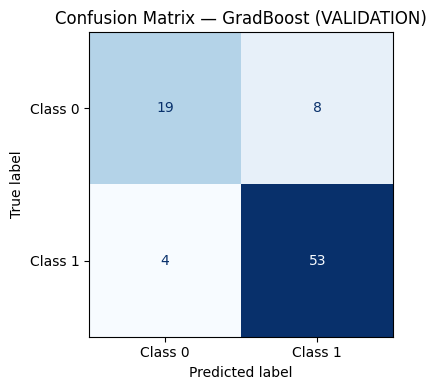

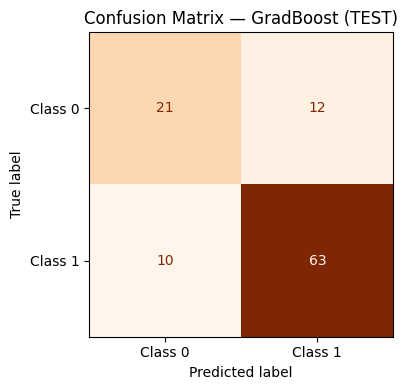

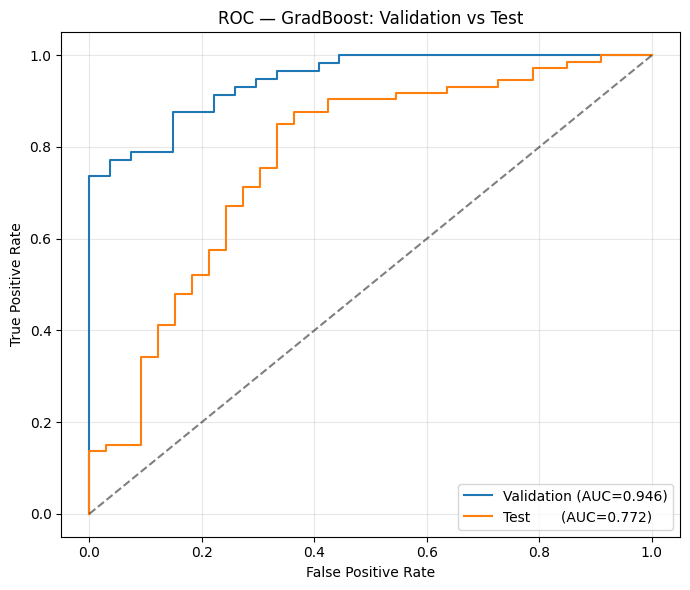

In [40]:
# ==== CELL 2: COMPARE BEST MODEL (from search) ON VALIDATION VS TEST =========
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

# This cell assumes the following objects from CELL 1:
# - best_models      (dict: best estimator per model family)
# - best_params      (dict: best hyperparameters per model family)
# - best_model_name  (str: best overall model by validation AUC)
# - X_val_scaled, y_val
# - X_test_scaled, y_test_full

best_model_val = best_models[best_model_name]

print(f"\n>>> Best model selected on VALIDATION (AUC): {best_model_name}")
print("Best params:", best_params[best_model_name])
print(best_model_val)

# Probabilities on validation and test
proba_val  = best_model_val.predict_proba(X_val_scaled)[:, 1]
proba_test = best_model_val.predict_proba(X_test_scaled)[:, 1]

# Hard predictions
y_pred_val  = best_model_val.predict(X_val_scaled)
y_pred_test = best_model_val.predict(X_test_scaled)

# AUC and macro F1 metrics
auc_val_best  = roc_auc_score(y_val,       proba_val)
auc_test_best = roc_auc_score(y_test_full, proba_test)

f1_val  = f1_score(y_val,       y_pred_val,  average="macro")
f1_test = f1_score(y_test_full, y_pred_test, average="macro")

print("\n=== VALIDATION vs TEST COMPARISON (BEST MODEL) ===")
print(f"Model:           {best_model_name}")
print(f"AUC  VAL    = {auc_val_best:.4f}")
print(f"AUC  TEST   = {auc_test_best:.4f}")
print(f"Macro F1 VAL  = {f1_val:.4f}")
print(f"Macro F1 TEST = {f1_test:.4f}")

print("\n--- CLASSIFICATION REPORT (VALIDATION) ---")
print(classification_report(y_val, y_pred_val, digits=4))

print("\n--- CLASSIFICATION REPORT (TEST) ---")
print(classification_report(y_test_full, y_pred_test, digits=4))

# Confusion matrices on validation and test
cm_val  = confusion_matrix(y_val,       y_pred_val)
cm_test = confusion_matrix(y_test_full, y_pred_test)

plt.figure(figsize=(5, 4))
disp_val = ConfusionMatrixDisplay(cm_val, display_labels=["Class 0", "Class 1"])
disp_val.plot(cmap="Blues", values_format="d", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix — {best_model_name} (VALIDATION)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=["Class 0", "Class 1"])
disp_test.plot(cmap="Oranges", values_format="d", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix — {best_model_name} (TEST)")
plt.tight_layout()
plt.show()

# ROC: validation vs test on the same plot
fpr_val,  tpr_val,  _ = roc_curve(y_val,       proba_val)
fpr_test, tpr_test, _ = roc_curve(y_test_full, proba_test)

plt.figure(figsize=(7, 6))
plt.plot(fpr_val,  tpr_val,  label=f"Validation (AUC={auc_val_best:.3f})")
plt.plot(fpr_test, tpr_test, label=f"Test       (AUC={auc_test_best:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC — {best_model_name}: Validation vs Test")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
